# Table of Contents

* [Search For Oscillation Frequencies](#section1)
    * [Download and Prepare the Data](#section_1_1)
    * [Simplify the Light Curve and Prepare it for `exoplanet`](#section_1_3)
    * [Other Calculations](#section_1_4)
        * [Phase-fold the Light Curve](#section_1_4_1)
        * [Calculate Time since Primary Eclipse](#section_1_4_2)
        * [Estimate the Phase Curve](#section_1_4_3)
        * [Find Time of Secondary Eclipses ](#section_1_4_4)
    * [Obtain MAP Models with `exoplanet`](#section_1_5)
        * [Choose Frequency Grid for the Periodogram](#section_1_5_1)
        * [Compute LS Periodogram of the out-of-eclipse Residuals](#section_1_5_2)
        * [Define `exoplanet` Model](#section_1_5_3)
    * [Evaluate Results](#section_1_6)
        * [Calculate Time of Periastron Passage¶](#section_1_6_1)
        * [Plot Phase Curve and Eclipse Models as a function of Iteration](#section_1_6_2)
        * [Plot Best Oscillation Models](#section_1_6_3)
        * [Storing and Plotting Pulsation Information](#section_1_6_4)
        
        
* [Time-Dependent Frequency Analysis](#section2)
    * [Check if the Data is Evenly Sampled](#section_2_1)
    * [Remember Sampling Properties of our Data ...](#section_2_2)
    * [Create Spectrogram of Unevenly Sampled Data](#section_2_3)
        * [Select your Window](#section_2_3_1)
        * [Define your Desired Time Resolution](#section_2_3_2)
        * [Create the Spectrogram's Time Array](#section_2_3_3)
        * [Generate the Spectrogram](#section_2_3_4)
    * [Plot Spectrogram Results](#section_2_4)

# Search For Oscillation Frequencies <a class="anchor" id="section1"></a>

Import Libraries and Configuration Parameters

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt
import warnings
import seaborn as sns
import statistics
from astropy.timeseries import LombScargle
import pandas as pd
import transitleastsquares as tls
import os
#time-frequency analysis
from scipy import interpolate, signal

In [2]:
# Remove when Theano is updated
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
fontsize = 30
label_size = 20
tick_size = 15

plt.rcParams['font.size'] = fontsize
plt.rcParams['axes.titlesize'] = label_size
plt.rcParams['axes.labelsize'] = label_size
plt.rcParams['xtick.labelsize'] = tick_size
plt.rcParams['ytick.labelsize'] = tick_size
plt.rcParams['figure.titlesize'] = fontsize

In [4]:
#Latex configuration
plt.rcParams['figure.figsize'] = 15, 6
plt.rcParams["figure.dpi"] = 150
plt.rcParams["savefig.dpi"] = 300
pgf_with_latex = {
    "pgf.texsystem": "xelatex",         # use Xelatex which is TTF font aware
    "text.usetex": True,                # use LaTeX to write all text
}
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update(pgf_with_latex)

In [5]:
kepler_tref = 2454833
villanova_tref = 2400000 

## Download and Prepare the Data
<a class="anchor" id="section_1_1"></a>

Note: Make sure the EB catalog from the Villanova Database is in the same folder as this Jupyter notebook.

In [6]:
def get_true_eb_values(name):
    #Extracts values from the EB Villanova Catalog
    catalog = pd.read_csv('catalog_of_EBs_with_SC.csv', sep = ",", index_col = '#KIC')
    
    #Period and t0
    P = catalog.loc[name, 'period']
    t0 = catalog.loc[name, 'bjd0']+villanova_tref-kepler_tref # Time of eclipse. Convention s.t. the primary (deeper) eclipse occurs at phase 0 (BJD-2400000)'
    
    ### In case they become useful in the future:
    #Other Physical Parameters
    R1 = catalog.loc[name, 'radius']
    M1 = catalog.loc[name, 'mass']
    teff = catalog.loc[name, 'teff']
    logg = catalog.loc[name, 'logg']
    feh = catalog.loc[name, 'feh']
    morph = catalog.loc[name, 'morph']
    
    #Light curve parameters
    pdepth = catalog.loc[name, 'pdepth'] #in flux units
    sdepth = catalog.loc[name, 'sdepth'] #in flux units
    pwidth = 2*catalog.loc[name, 'pwidth'] #in Phase units (it seems to be 1/2 the eclipse duration, so that's why we multiply it by 2)
    swidth = 2*catalog.loc[name, 'swidth']
    
    return P, t0, pwidth, swidth

In [7]:
def load_kepler_lc(name):
    #Retrieve all the existing short-cadence photometry on this system.
    data = lk.search_lightcurvefile(
        'KIC%s'%name, 
        cadence = cadence_type,
        mission = 'kepler').download_all()
    print(data)
    lc_data = data.SAP_FLUX.stitch().remove_nans().remove_outliers(sigma = 3.0, sigma_lower = float('inf'))
    tformat = lc_data.time_format
    return lc_data, data, tformat

In [8]:
KIC = 4544587 #4544587 
cadence_type = "short"
lit_period, lit_t0, pwidth, swidth = get_true_eb_values(KIC)
print("Orbital Period = %0.02f d" %lit_period)
print("Time of Eclipse = %0.02f d" %lit_t0)

Orbital Period = 2.19 d
Time of Eclipse = 121.14 d


In [9]:
kepler_lc, lcfs, tformat = load_kepler_lc(KIC);
print(len(kepler_lc.time))

/Users/mbadenas/opt/anaconda3/envs/mit37_mkl/lib/python3.7/site-packages/lightkurve/lightcurvefile.py:47: LightkurveWarning: `LightCurveFile.header` is deprecated, please use `LightCurveFile.get_header()` instead.
  LightkurveWarning)


LightCurveFileCollection of 13 objects:
	KIC 4544587 (13 KeplerLightCurveFiles) Quarters: 3,7,7,7,8,8,8,9,9,9,10,10,10

539181


## Simplify the Light Curve and Prepare it for `exoplanet` 
<a class="anchor" id="section_1_3"></a>

In [10]:
def get_gaps_indexes(time, break_tolerance):
    #Adapted from Wotan (https://github.com/hippke/wotan/blob/382f5bfd73f8ca31522af0e4fa64cd4813441886/wotan/gaps.py)
    """Array indexes where ``time`` has gaps longer than ``break_tolerance``"""
    gaps = np.diff(time)
    gaps_indexes = np.where(gaps > break_tolerance)
    gaps_indexes = np.add(gaps_indexes, 1) # Off by one :-)
    gaps_indexes = np.concatenate(gaps_indexes).ravel()  # Flatten
    gaps_indexes = np.append(np.array([0]), gaps_indexes)  # Start
    gaps_indexes = np.append(gaps_indexes, np.array([len(time)+1]))  # End point
    
    num_gaps = len(gaps_indexes)
    
    return gaps_indexes, num_gaps

(array([     0,  43979, 171544, 209079, 265474]),
 array([    -1,  43978, 171543, 209078, 265473]))

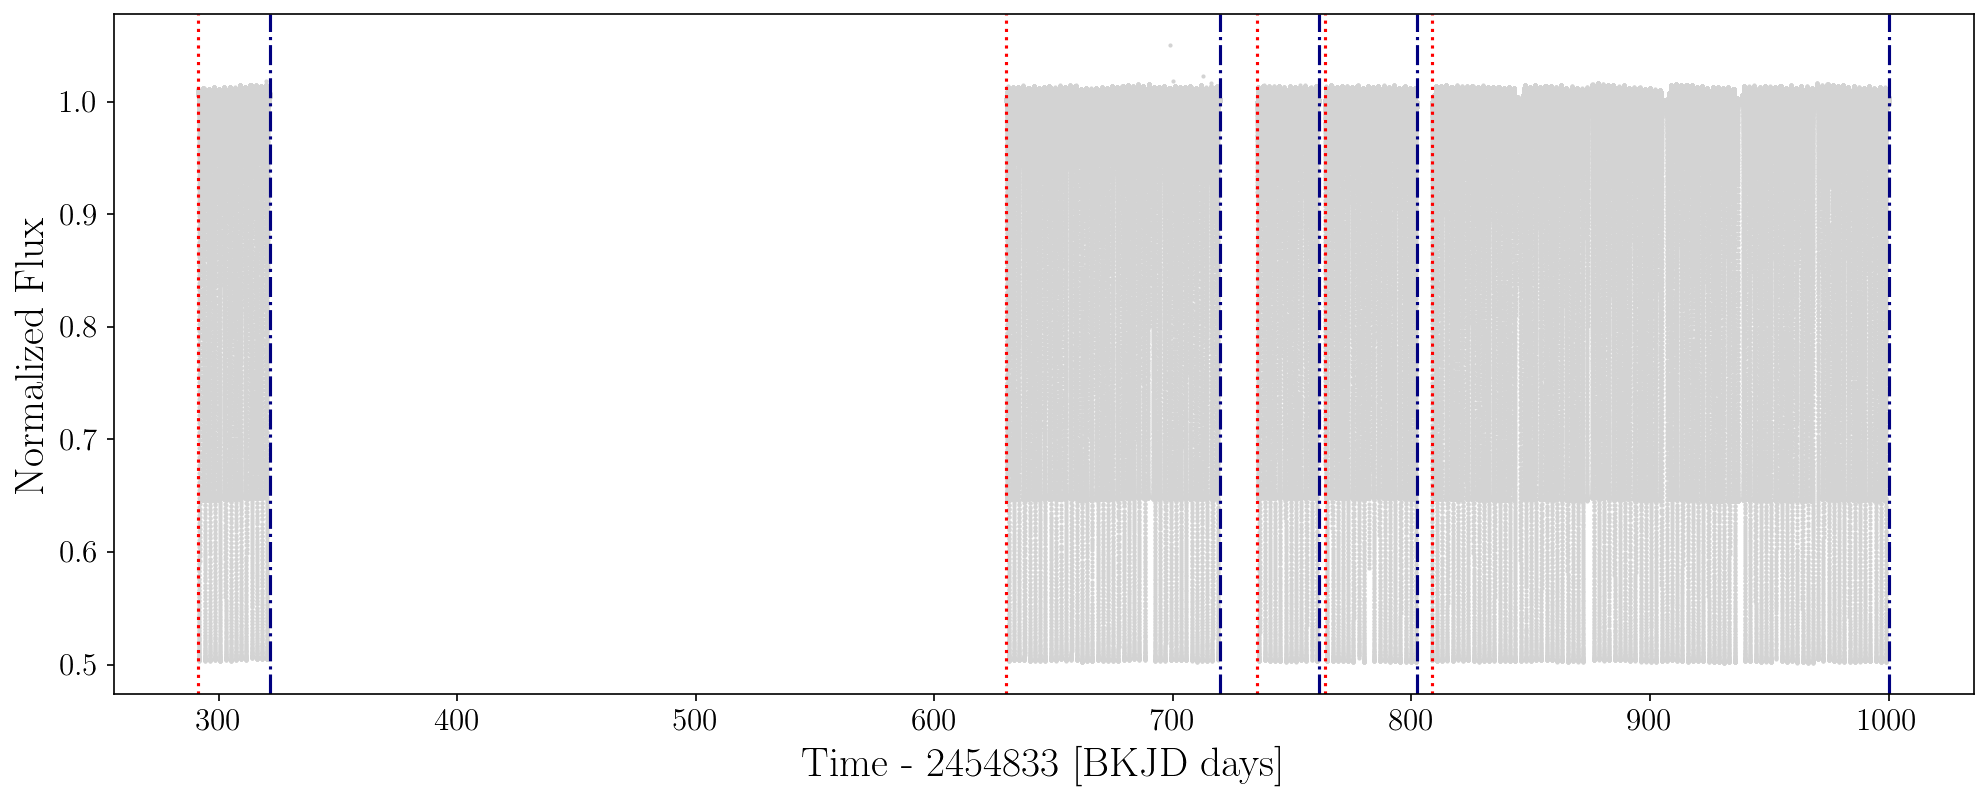

In [11]:
init_gaps, ngaps = get_gaps_indexes(kepler_lc.time, 1)
init_gaps = init_gaps[0:-1]
end_gaps = init_gaps-1

fig, ax = plt.subplots(1,1, figsize=(16,6))
kepler_lc.scatter(c="lightgrey",s=1, ax=ax, label = None)
for i in init_gaps:
    ax.axvline(kepler_lc.time[i], color="red", lw=1.5, ls = ":")

for e in end_gaps:
    ax.axvline(kepler_lc.time[e], color="navy", lw=1.5, ls = "-.")
    
init_gaps, end_gaps

Select Chunk

In [12]:
init_chunk = init_gaps[2]
end_chunk = end_gaps[3]

print("We'll study the segment comprised between points %i and points %i" %(init_chunk, end_chunk))
lc_mask = (kepler_lc.time >= kepler_lc.time[init_chunk]) & (kepler_lc.time <= kepler_lc.time[end_chunk])

We'll study the segment comprised between points 171544 and points 209078


In [13]:
chunk_name = str(init_chunk)+"_"+str(end_chunk)+"/"
fpath = "results/"
arr = os.listdir(fpath)
folders = ["data", "diagnostics", "tfreq_analysis", "map"]

if not os.path.exists(fpath+chunk_name):
        os.makedirs(fpath+chunk_name)
else: print("folder already exists!")
        
for f in folders:
    if not os.path.exists(fpath+chunk_name+f):
        os.makedirs(fpath+chunk_name+f)
        
fpath_chunk = fpath + chunk_name
fpath_chunk

'results/171544_209078/'

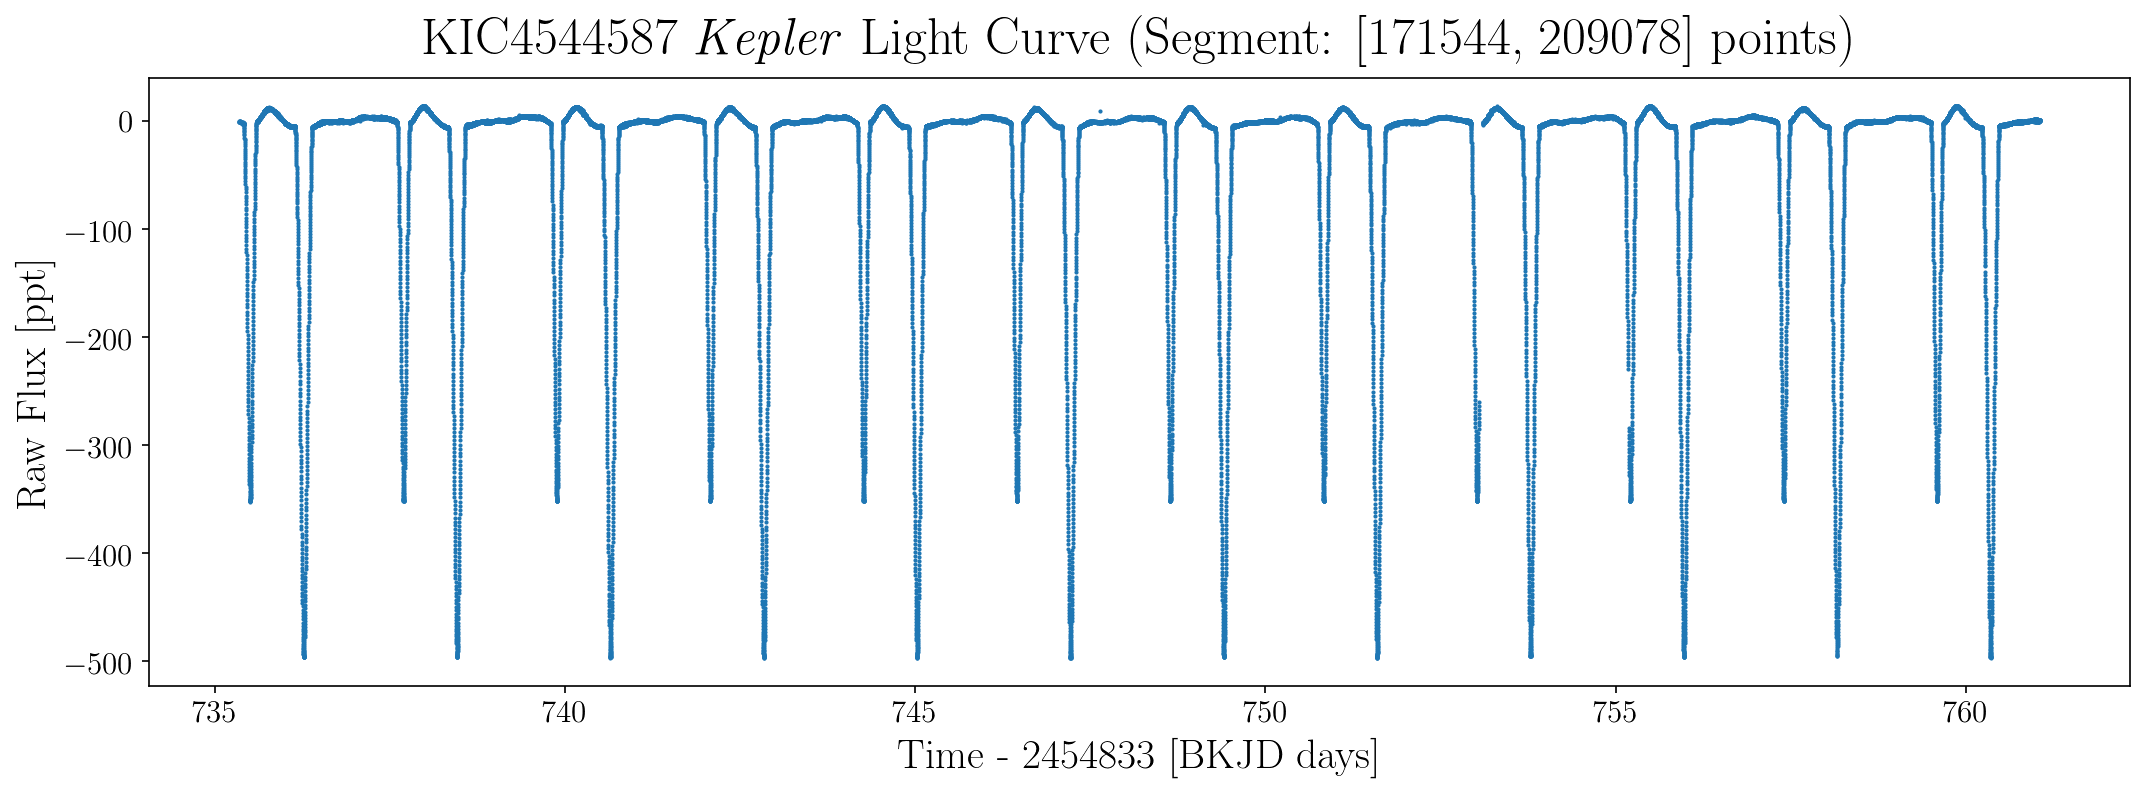

In [14]:
x = np.ascontiguousarray(kepler_lc.time[lc_mask], dtype=np.float64)
y = np.ascontiguousarray(kepler_lc.flux[lc_mask], dtype=np.float64)
yerr = np.ascontiguousarray(kepler_lc.flux_err[lc_mask], dtype=np.float64)
mu = np.median(y)
y = (y / mu - 1) * 1e3

#cut_lc = lk.KeplerLightCurve(time=x, flux=y, flux_err = yerr)

fig, ax = plt.subplots(1,1)
ax.scatter(x,y,s = 1)
ax.set(xlabel="Time - %i [BKJD days]"%kepler_tref, ylabel = 'Raw Flux [ppt]')#, xlim=(295,300))
ax.set_title(r"KIC%s $\it{Kepler}$ Light Curve (Segment: [%i, %i] points)" %(KIC, init_chunk, end_chunk), fontsize = 25, y=1.02);

fig.tight_layout()
fig.savefig(fpath_chunk+"data/lc.png")

## Other Calculations
<a class="anchor" id="section_1_4"></a>

### Find Time of Secondary Eclipses 
<a class="anchor" id="section_1_4_4"></a>

In [15]:
def get_t0_secondary(lc_primary_masked):
    KIC_params = tls.catalog_info(KIC_ID=KIC)
    ld, M_star, M_star_l, M_star_u, R_star, R_star_l, R_star_u = KIC_params;

    if not np.isfinite(R_star): R_star = 1.
    if not np.isfinite(M_star): M_star = 1.
    if not np.isfinite(M_star_u): M_star_max = M_star
    else: M_star_max = M_star+3*M_star_u
    if not np.isfinite(M_star_l): M_star_min = 0.08
    else: M_star_min = np.max([M_star-3*M_star_l, 0.08])
    if not np.isfinite(R_star_u): R_star_max = np.max([R_star, 3.5])
    else: R_star_max = R_star+3*R_star_u
    if not np.isfinite(R_star_l): R_star_min = 0.08
    else: R_star_min = np.max([R_star-3*R_star_l, 0.08])
    print(ld, M_star, M_star_l, M_star_u, R_star, R_star_l, R_star_u)
    print(ld, M_star, M_star_min, M_star_max, R_star, R_star_min, R_star_max)

    model = tls.transitleastsquares(
        lc_primary_masked.time, 
        lc_primary_masked.flux, 
        lc_primary_masked.flux_err
    )
    
    results = model.power(
        M_star=M_star, M_star_min=M_star_min, M_star_max=M_star_max,
        R_star=R_star, R_star_min=R_star_min, R_star_max=R_star_max,
        u=ld, 
        period_min = lit_period-1.0, period_max=lit_period+1.0
    )
    
    summarize_tls_results(results)
    return results.T0

def mask_transits(data, eclipse_duration, t0):
    intransit = tls.transit_mask(data.time, 
                                 lit_period, 
                                 transit_window*eclipse_duration*lit_period, 
                                 t0) #multiply the duration pwdith by P to convert it from phase units to days
    eclipses = data[intransit]
    lc_masked = data[~intransit]
    return lc_masked, eclipses


def summarize_tls_results(results):
    print(f'Period = {results.period:.5f} +/- {results.period_uncertainty:.5f} d')
    print('Transit depth = ', format(results.depth, '.5f'))
    print("T0 = ", format(results.T0, '.5f'))
    print('Best duration (days) = ', format(results.duration, '.5f'))
    print('Signal detection efficiency (SDE) = ', results.SDE)
    print('Signal-to-noise ratio (SNR) = ', results.snr)

In [16]:
transit_window = 1
lc_primary_masked, primary_transits = mask_transits(kepler_lc[lc_mask], pwidth, lit_t0) #can't seem to get good results if i simply use cut_lc as input
t0_secondary = get_t0_secondary(lc_primary_masked)
lc_wo_eclipses, secondary_transits = mask_transits(lc_primary_masked, swidth, t0_secondary)

(0.1998, 0.4073) 2.078 0.498 0.332 2.416 0.759 0.506
(0.1998, 0.4073) 2.078 0.5840000808238983 3.0740000307559967 2.416 0.13899987936019897 3.9339998364448547


/Users/mbadenas/opt/anaconda3/envs/mit37_mkl/lib/python3.7/site-packages/transitleastsquares/validate.py:31: UserWarning: Warning: The mean flux should be normalized to 1, but it was found to be 0.9851425230225457
  warnings.warn(text)
  0%|          | 0/295 periods | 00:00<?

Transit Least Squares TLS 1.0.25 (04 June 2020)
Creating model cache for 28 durations
Searching 30916 data points, 295 periods from 1.565 to 3.189 days
Using all 8 CPU threads


100%|██████████| 295/295 periods | 00:13<00:00


Period = 2.18731 +/- 0.00792 d
Transit depth =  0.71692
T0 =  735.51797
Best duration (days) =  0.10490
Signal detection efficiency (SDE) =  13.406327583691775
Signal-to-noise ratio (SNR) =  1047.4392623935746


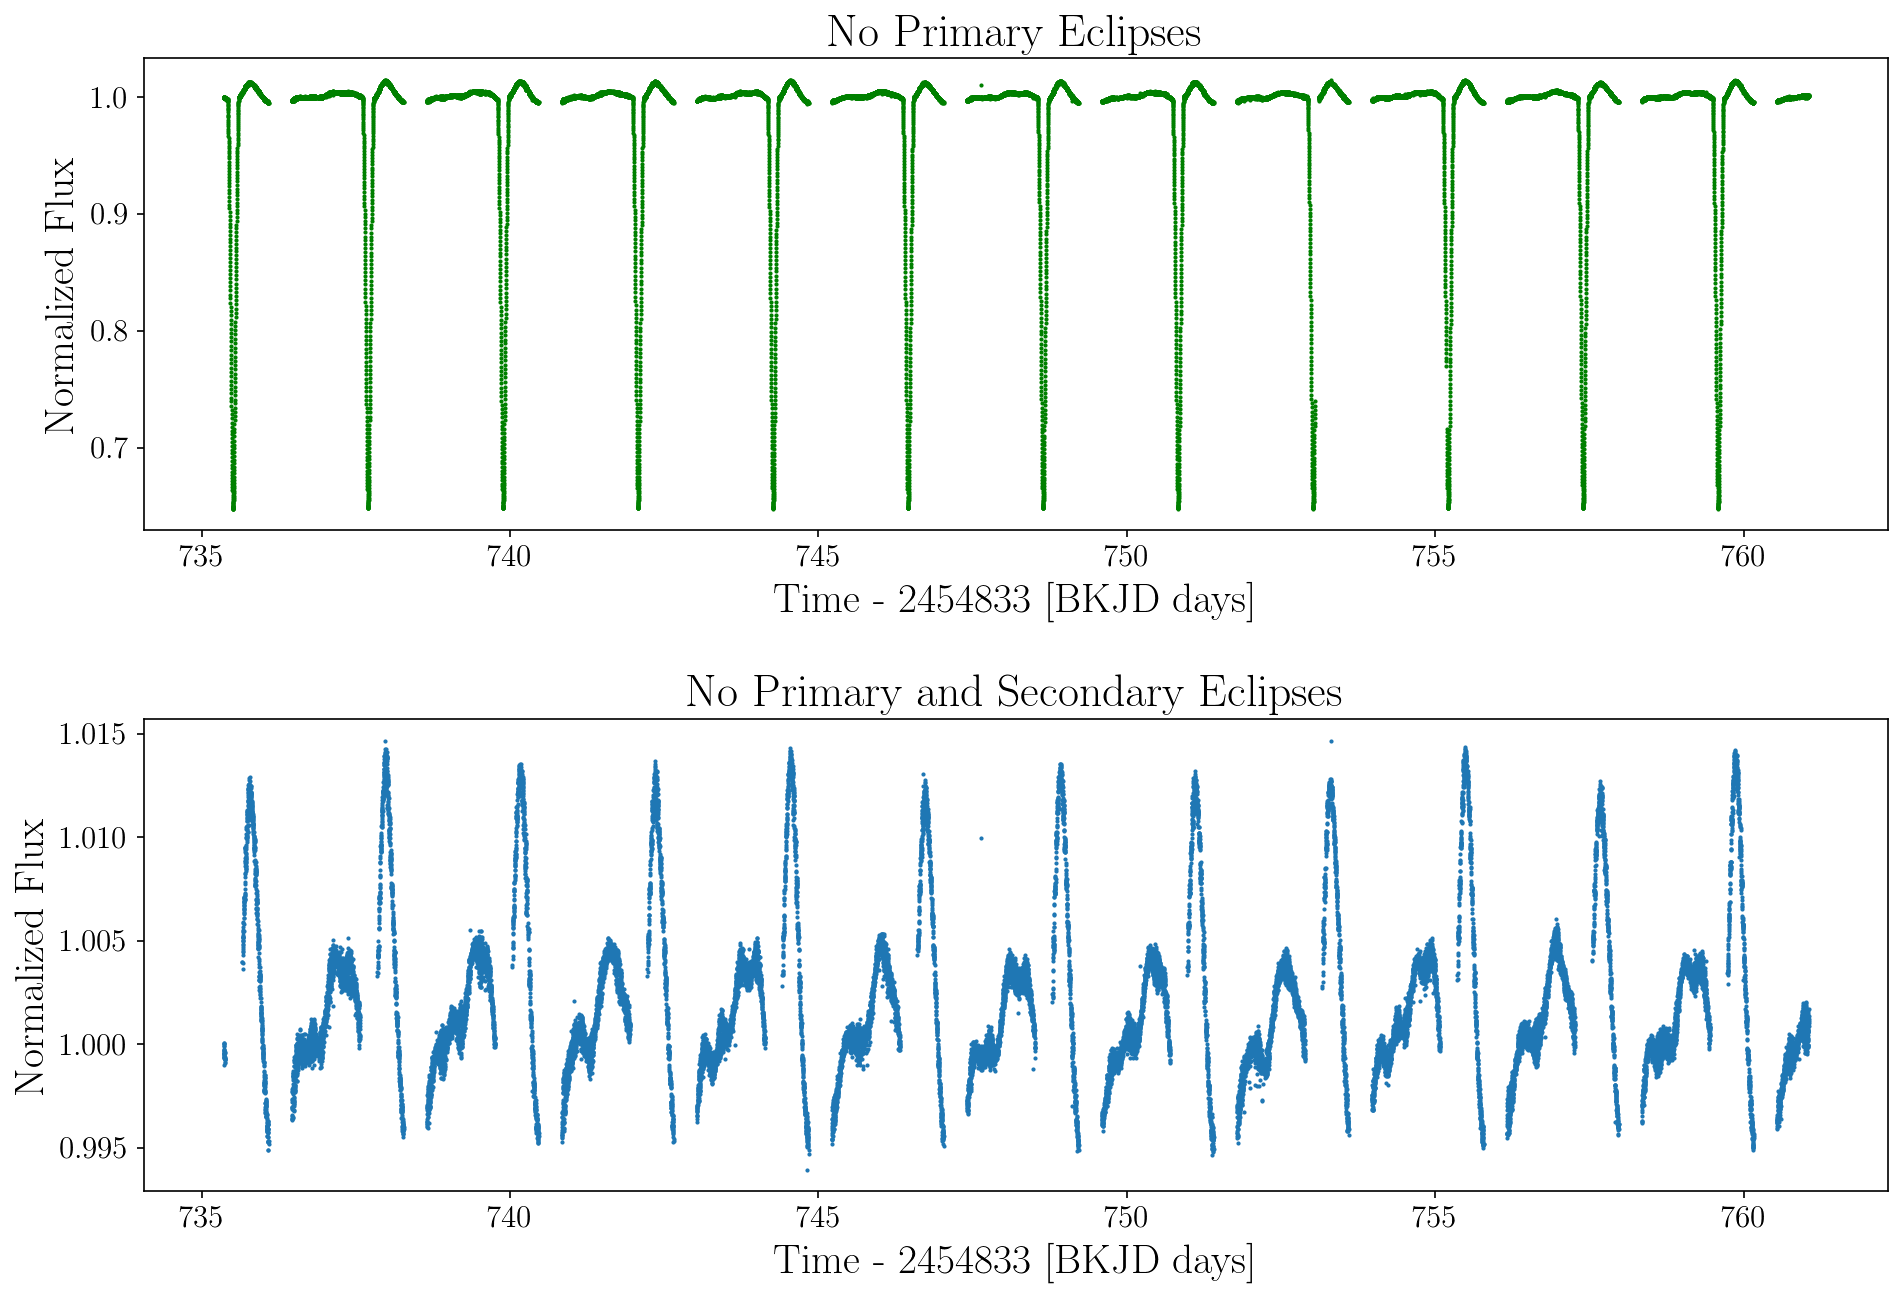

In [17]:
fig, ax = plt.subplots(2,1, figsize=(15,10))
fig.subplots_adjust(hspace=0.4)

lc_primary_masked.scatter(c='green', s=1, ax=ax[0], xlabel="Time - %i [BKJD days]"%kepler_tref, label = None)
lc_wo_eclipses.scatter(s=1, ax=ax[1], xlabel="Time - %i [BKJD days]"%kepler_tref, label = None)

ax[0].set_title('No Primary Eclipses', fontsize=22);
ax[1].set_title('No Primary and Secondary Eclipses', fontsize=22);

fig.savefig(fpath_chunk+"data/masked_transits.png")

### Phase-fold the Light Curve
<a class="anchor" id="section_1_4_1"></a>

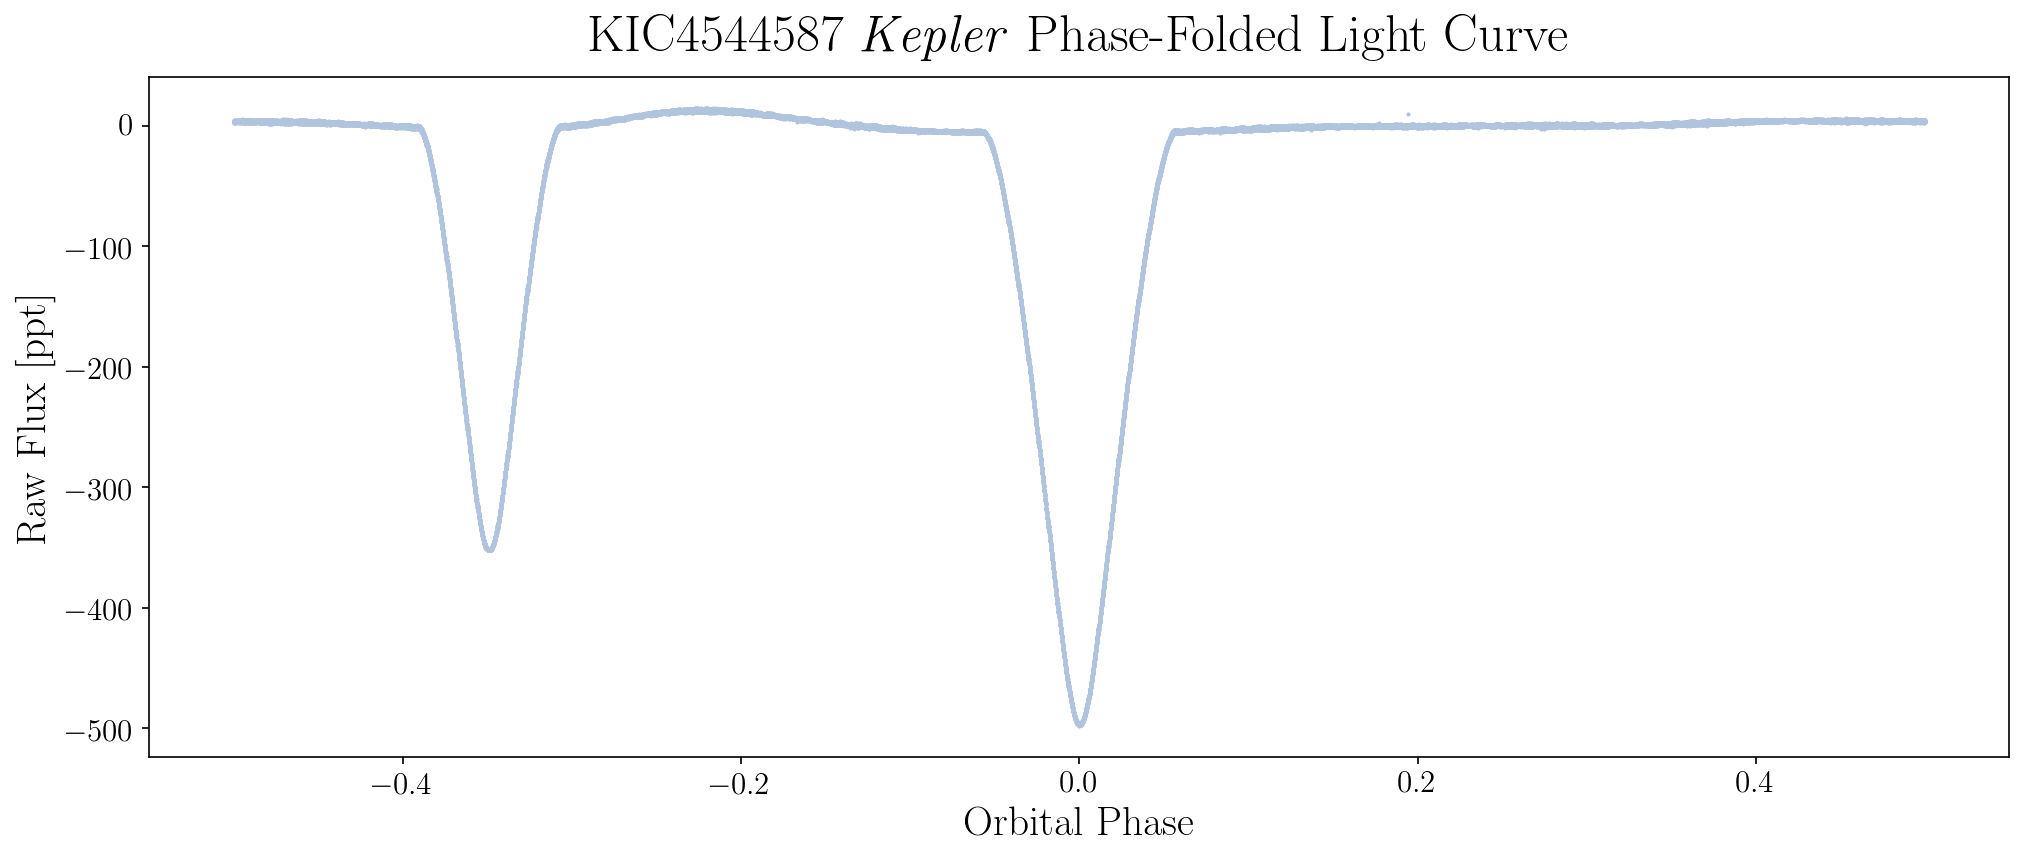

In [18]:
x_fold_in_phase = ((x - lit_t0 + 0.5 * lit_period) % lit_period)/lit_period - 0.5 #equivalent to cut_lc.fold(period=lit_period, t0 = lit_t0)
fig, ax = plt.subplots(1,1, figsize=(16,6)) 
ax.scatter(x_fold_in_phase, y, c="lightsteelblue", s=1)
ax.set(xlabel="Orbital Phase", ylabel = 'Raw Flux [ppt]')
ax.set_title(r"KIC%s $\it{Kepler}$ Phase-Folded Light Curve" %KIC, fontsize = 25, y=1.02);
fig.savefig(fpath_chunk+"data/lc_folded.png")

### Calculate Time since Primary Eclipse
<a class="anchor" id="section_1_4_2"></a>

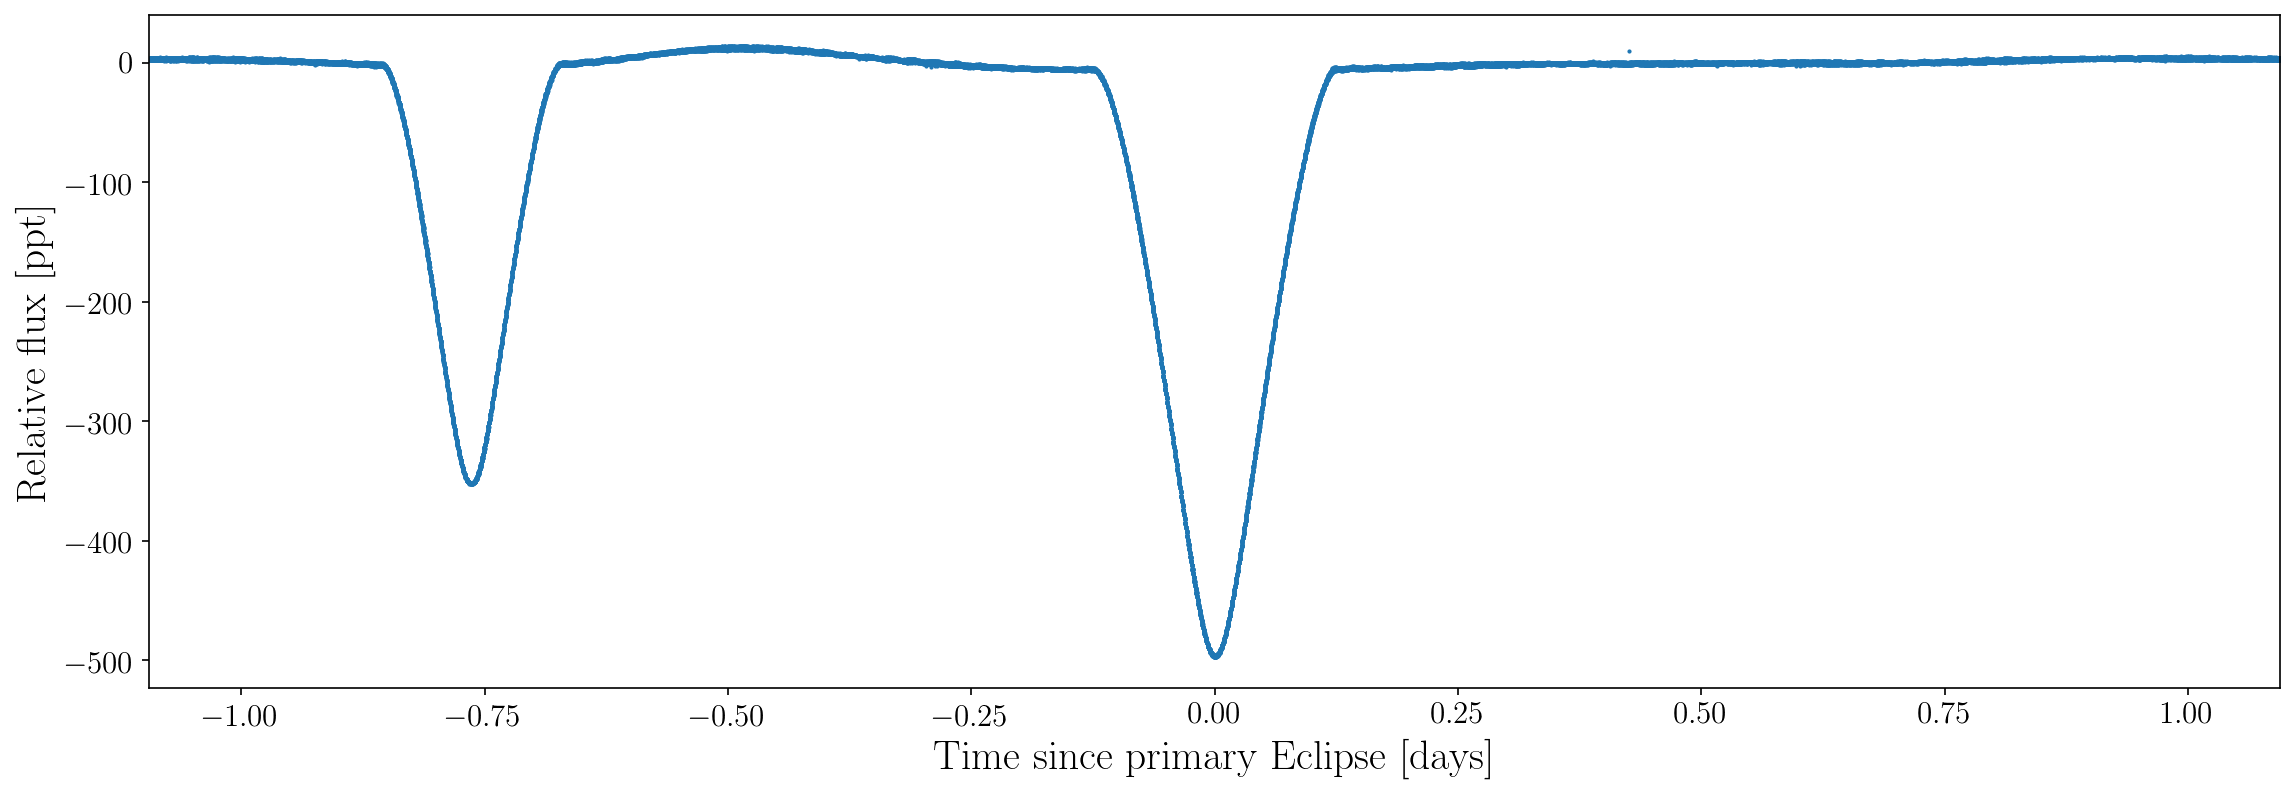

In [19]:
x_fold = (x - lit_t0 + 0.5 * lit_period) % lit_period - 0.5*lit_period

fig, ax = plt.subplots(1,1, figsize=(16,6))
ax.scatter(x_fold, y,  s=1)
ax.set(
    xlim = (-0.5 * lit_period, 0.5 * lit_period), 
    xlabel = "Time since primary Eclipse [days]",
    ylabel = "Relative flux [ppt]")
fig.tight_layout()

### Estimate the Phase Curve
<a class="anchor" id="section_1_4_3"></a>

In [20]:
bin_edges = lit_period * np.linspace(-0.5, 0.5, 5000)
num, _ = np.histogram(x_fold, bin_edges, weights=y)
denom, _ = np.histogram(x_fold, bin_edges)

x_smooth = 0.5 * (bin_edges[1:] + bin_edges[:-1])
y_smooth = num / denom
m = np.abs(x_smooth) > 0.5
second_phase = x_smooth[m][np.argmin(y_smooth[m])]

x_smooth = np.concatenate(([2 * x_smooth[0] - x_smooth[1]], x_smooth, [2 * x_smooth[-1] - x_smooth[-2]]))
y_smooth = np.concatenate(([y_smooth[-1]], y_smooth, [y_smooth[0]]))
mod = np.interp(x_fold, x_smooth, y_smooth) 

Compute the out-of-eclipse residuals from this phase curve

In [21]:
mask = (np.abs(x_fold - second_phase) > 0.2) & (np.abs(x_fold) > 0.2)
resid = y - mod
sigma = np.nanmedian(resid[mask] ** 2) #compute median while ignorning nan
nan_residm = np.where(resid[mask] is np.nan)
print("Sigma of Out-of-Eclipse Residuals: %0.03f" %sigma)
mask[mask] &= np.abs(resid[mask]) < 20 * sigma

Sigma of Out-of-Eclipse Residuals: 0.196


Plot smoothed phase curve

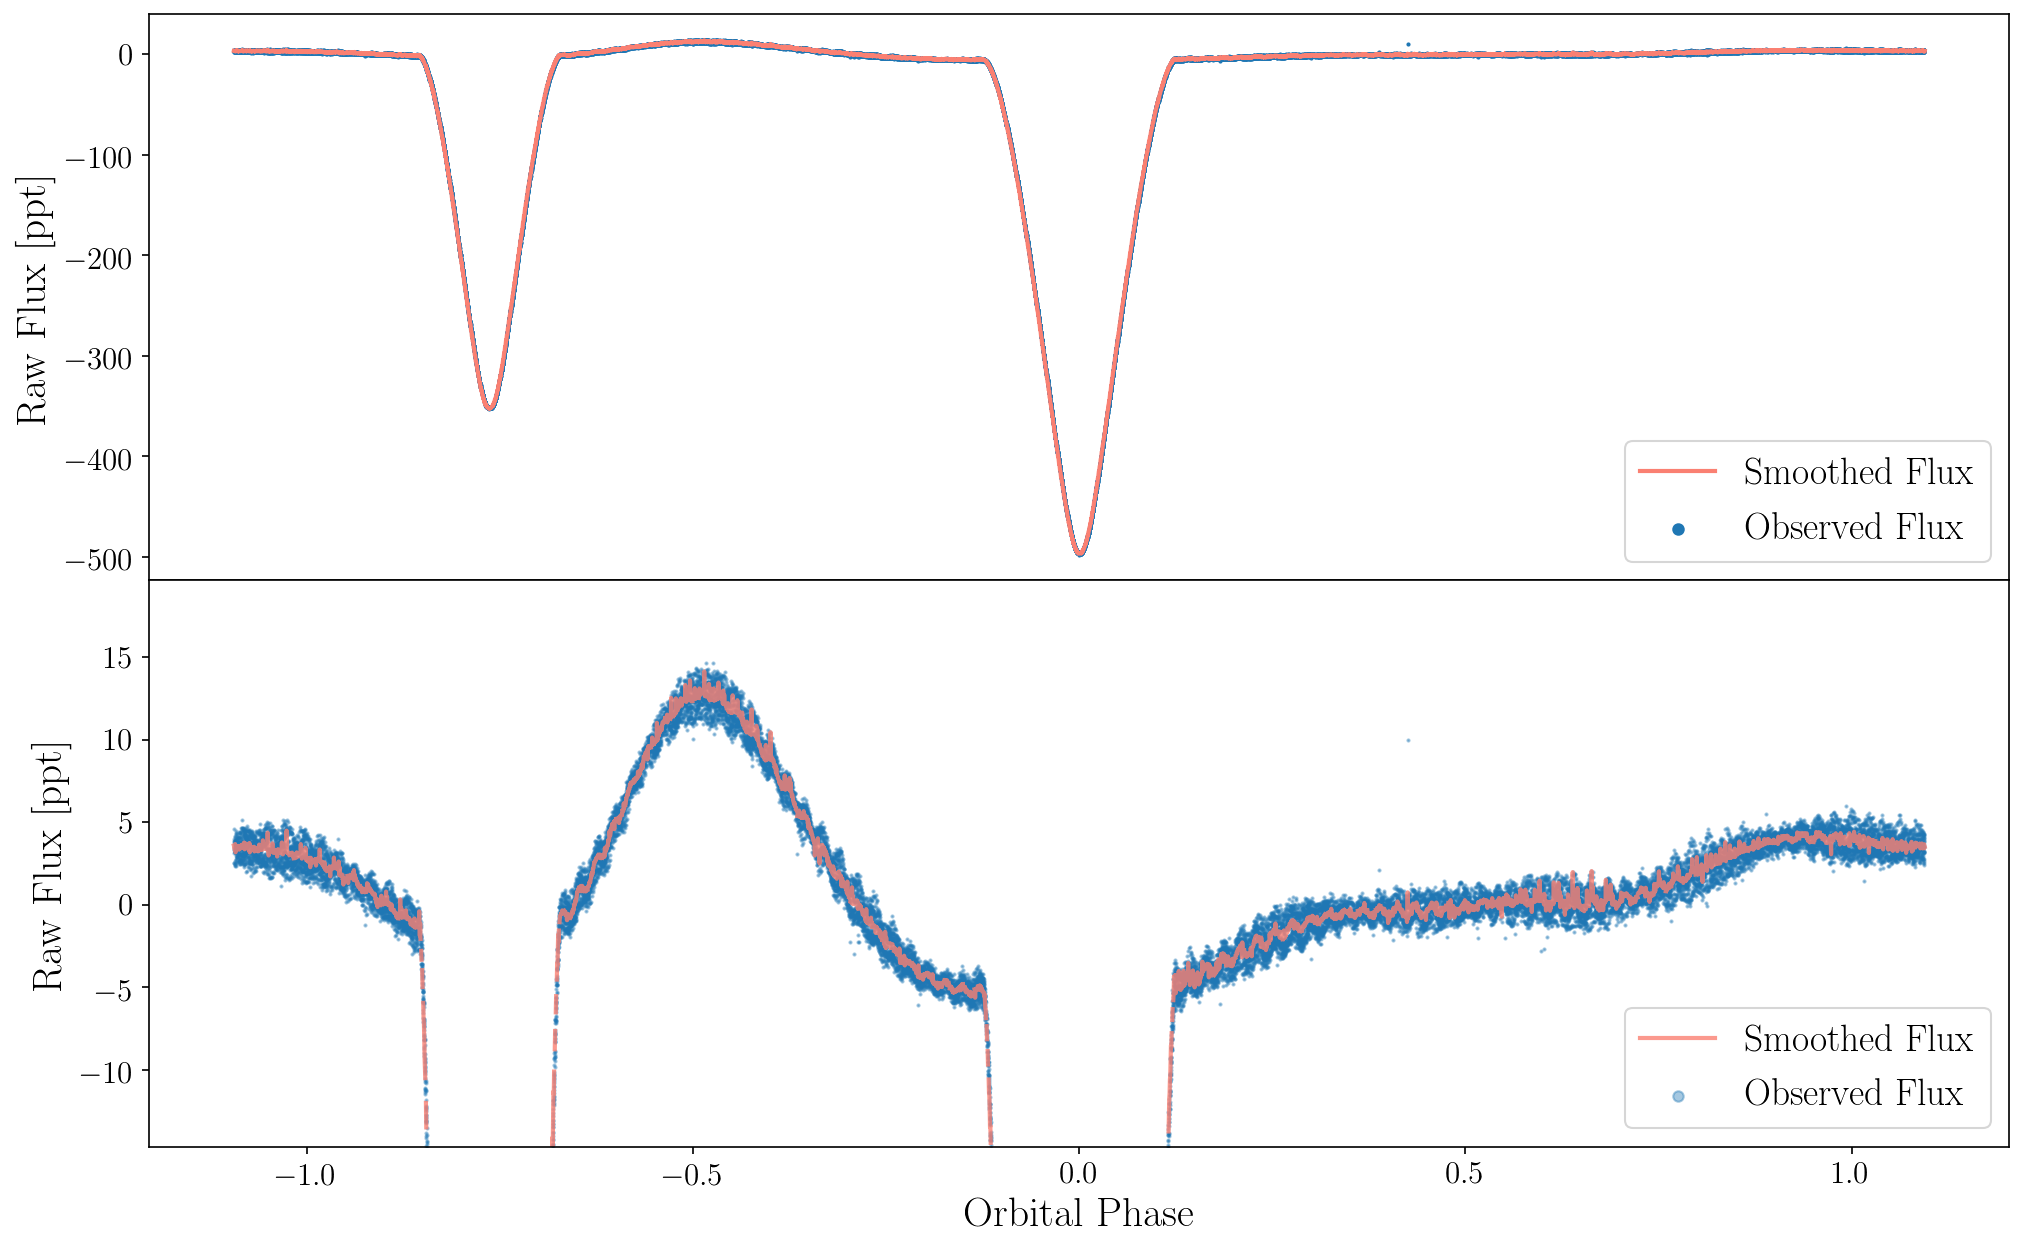

In [22]:
fig, ax = plt.subplots(2,1, sharex=True, figsize=(16,10))
fig.subplots_adjust(hspace=0.0)
ax[0].scatter(x_fold, y, s=1, label = "Observed Flux")
ax[0].plot(x_smooth, y_smooth, lw = 2, c = 'salmon', label = 'Smoothed Flux');
ax[0].legend(fontsize=18, markerscale=5, loc = "lower right")
ax[0].set(ylabel="Raw Flux [ppt]");
ax[1].scatter(x_fold, y, s=1, alpha = 0.4, label = "Observed Flux")
ax[1].plot(x_smooth, y_smooth, lw = 2, c = 'salmon', alpha = 0.8,label = 'Smoothed Flux');
ax[1].set(xlabel = "Orbital Phase", ylabel="Raw Flux [ppt]", ylim=(-y.max(),y.max()+5));
ax[1].legend(fontsize=18, markerscale=5, loc = "lower right");

Plot the Out-of-eclipse Residuals

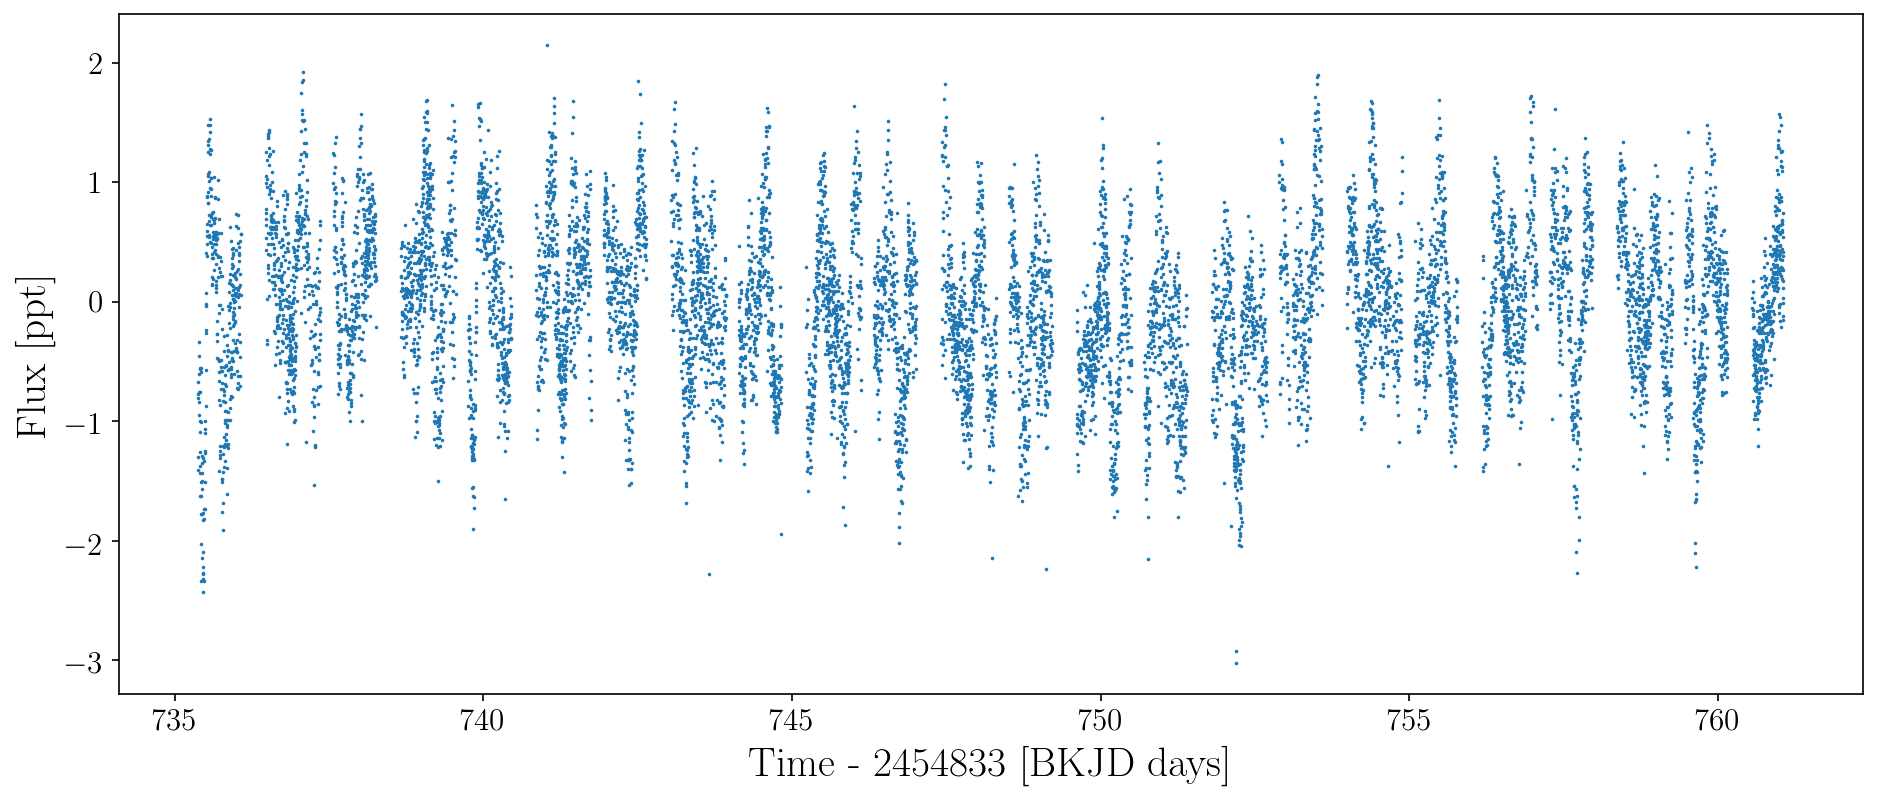

In [23]:
fig, ax = plt.subplots(1,1)
ax.scatter(x[mask], resid[mask], s=0.5) 
ax.set(xlabel="Time - %i [BKJD days]"%kepler_tref, ylabel="Flux [ppt]")

x_oot = x[mask]
y_oot = resid[mask]

In [24]:
print("The time of the secondary is %0.08f d" %t0_secondary)

The time of the secondary is 735.51796794 d


## Obtain MAP Models with `exoplanet` 
<a class="anchor" id="section_1_5"></a>

In [25]:
def ls_estimator(time, flux, frequencies, npeaks):
    #Function based on Dan's LS estimator code but adjusted for a variable frequency grid
    #(https://github.com/exoplanet-dev/exoplanet/blob/main/src/exoplanet/estimators.py)
    
    periods = 1./frequencies
    model = LombScargle(time, flux)
    powers = model.power(frequencies, method="fast", normalization="psd")
    
    powers /= len(time)
    power_est = np.array(powers)
    
    # Identify Peaks 
    peaks = xo.find_peaks(frequencies, powers, max_peaks=npeaks)
    
    return dict(periodogram=(frequencies, power_est), peaks=peaks, ls=model)


def detect_oscillations(time, flux, ls_model, optional_it):
    ls = ls_model["ls"];
    frequencies, powers = ls_model['periodogram']
    periods = 1.0/frequencies
    best_frequency = frequencies[np.argmax(powers)]
    best_period = 1./best_frequency
    
    print("Best Frequency = %0.04f d^-1" % best_frequency)
    #FAP Levels
    log_probs = np.array([-2, -4, -6])
    fals = ls.false_alarm_level(10.**log_probs)
    
    # Hack to remove nearby modes
    peak_freq = np.array([1.0/ls_model["peaks"][0]["period"]])
    peak_log_power = [ls_model["peaks"][0]["log_power"]]
    
    for peak in ls_model["peaks"][1:]:
        freq = 1.0 / peak["period"]
        if np.any(np.abs(peak_freq - freq) < 0.2):
            continue
        peak_freq = np.append(peak_freq, freq)
        peak_log_power.append(peak["log_power"])
    print(f"--> I have found %s frequencies (max. allowed nº of freqs: %s)" %(len(peak_freq), npeaks))
    
    # Only store peaks above FAP=10^-2
    peak_power = np.exp(peak_log_power)
    fap_mask = (peak_power > fals[0])
    peak_freq = peak_freq[fap_mask] 
    peak_power = peak_power[fap_mask]
    print(f"--> I have found {len(peak_freq)} frequencies with FAP > 10^-2")
    
    #Plot periodogram
    fig  = plt.figure(figsize=(20,15))
    #fig.suptitle("Lomb Scargle Periodogram",y=1.02)
    fals_palette = sns.color_palette("coolwarm");
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(212)
    
    #Frequency domain
    ax1.plot(frequencies, powers, c='grey')
    for idx, (log_prob, fal) in enumerate(zip(log_probs, fals)):
        ax1.axhline(fal, ls='--', lw=2, c=fals_palette[idx], label = f'FAP = 10$^{{{log_prob}}}$')
    ax1.set(xlabel=r"Frequency $f$ [$d^{-1}$]", ylabel = "Power", title="Frequency Domain");
    ax1.legend(fontsize=12)
    
    #Time domain
    ax2.plot(periods, powers, c ='grey')
    ax2.axvline(best_period, alpha=0.2, lw=3,c='purple')
    for i, (log_prob, fal) in enumerate(zip(log_probs, fals)):
        ax2.axhline(fal, ls='--', lw=2, color=fals_palette[i], label = f'FAP = 10$^{{{log_prob}}}$')
    ax2.set(xlabel=r"Period [d]", ylabel = "Power", title = "Time Domain")
    ax2.legend(fontsize=12)
    
    #plot dots
    cdots = sns.color_palette("Paired", npeaks)

    for idx, (f, p) in enumerate(zip(peak_freq, peak_power)):
        ax1.plot(f, p, "o", c=cdots[idx])
        ax2.plot(1./f, p, "o", c=cdots[idx])
        
    # Find harmonics within dist_to_integer 
    dist_to_integer = 0.001 #1e-2
    orbital_frequency = 1.0/lit_period
    
    freq_norm = frequencies/orbital_frequency
    peak_freq_norm = peak_freq/orbital_frequency
    resonant_peak_freq = freq_norm[np.abs(freq_norm-np.round(freq_norm)) <= dist_to_integer]
    
    ax3.plot(freq_norm, powers, color='grey') #plot f/forb
    
    for r in resonant_peak_freq:
        ax3.axvline(r, ls=':', lw=1., c='navy') # plot harmonics 
        
    for (idx, peak) in enumerate(peak_freq_norm): # plot peaks identified before
        ax3.plot(peak, peak_power[idx], "o", c=cdots[idx], label = r"$f/f_{orb}$=%0.03f"%peak)
    
    # Adjust x-lim of orbital harmonics plot for the ~~~aesthetics 
    if len(peak_freq_norm) != 0: 
        ax3.set(xlabel=r"f/f$_{orbit}$", ylabel = "Power", title = 'Orbital Harmonics', xlim=(min(peak_freq_norm)-2, 5 + max(peak_freq_norm)));
    ax3.legend(fontsize=12)
    
    if optional_it is not None: 
        fig.tight_layout()
        fig.savefig(fpath_chunk+'map/ls_periodogram_'+optional_it+'.png')
    else: 
        fig.tight_layout()
        fig.savefig(fpath_chunk+'map/ls_periodogram_0.png')
    
    #freq2dhms(peak_freq)
    
    print("--> I have found %s resonant frequencies in the periodogram!" %len(resonant_peak_freq))
    
    plt.pause(0.05)
    plt.close("all")
    
    return peak_freq, peak_power

### Choose Frequency Grid for the Periodogram
<a class="anchor" id="section_1_5_1"></a>


#### Apply Nyquist Theorem: 

Given the sampling frequency $f_s$ of a uniformly sampled real signal, the maximum frequency that can be detected without aliasing phenomena is 
\begin{equation}
f_{max} = \frac{f_s}{2} \text{.}
\end{equation}
See VanderPlas 2018 (https://iopscience.iop.org/article/10.3847/1538-4365/aab766/meta)

In [26]:
sampling_rate = np.median(np.diff(x)) # [d]
short_cadence = 58.85/60./60./24. # This is the Kepler SC, in days
sampling_rate, short_cadence # Note that sampling_rate is essentially the same as Kepler's short cadence

(0.0006810974373365752, 0.0006811342592592593)

In [27]:
fs = 1./sampling_rate # sampling frequency [1/d]
fmax = fs/2. #f_nyquist = fs/2
fs, fmax

(1468.2187087804793, 734.1093543902397)

Let the user define the min. and max. frequencies for the frequency grid of the periodogram. 

In [28]:
orbital_frequency = 1/lit_period
minfr = 5*orbital_frequency #[d^-1] or 1/(total_duration)
maxfr = 200 #[d^-1]

In [29]:
dt = np.median(np.diff(x)) # [d] # Time span between consecutive samples
fs = 1.0/dt # Sampling frequency [1/d]
total_duration = x.shape[0]/fs #total duration of data
dt, fs, total_duration

(0.0006810974373365752, 1468.2187087804793, 25.56499231042835)

In [30]:
N_samples_per_peak = 20
df = 1/(total_duration*N_samples_per_peak)
grid_resolution = (maxfr-minfr)/df+1
freq_grid = np.linspace(minfr, maxfr, int(grid_resolution))
print("Nº of samples per peak = %i" %N_samples_per_peak)
print("Grid Resolution = %i" %grid_resolution)
print("Delta(Frequency) btw Observations (using %i samples per peak) = %0.09f d^-1"%(N_samples_per_peak, df))
print("Delta(Frequency) btw Observations in our Frequency Grid = %0.09f d^-1"%(freq_grid[1]-freq_grid[0]))
print("Nº of Frequency Points (using a delta frequency of %0.08f d^-1) = %i" %(df, grid_resolution))

#Compare with Old Version
df_3E5 = (maxfr-minfr)/(30000-1)
print("## Nº of Samples if we used 30.000 frequency points = %0.02f" %(1/(total_duration*df_3E5))) #number of samples per peak if we used grid_resolution = 30000 (as in old version)

Nº of samples per peak = 20
Grid Resolution = 101093
Delta(Frequency) btw Observations (using 20 samples per peak) = 0.001955800 d^-1
Delta(Frequency) btw Observations in our Frequency Grid = 0.001955802 d^-1
Nº of Frequency Points (using a delta frequency of 0.00195580 d^-1) = 101093
## Nº of Samples if we used 30.000 frequency points = 5.93


In [31]:
print("Length frequency grid: ", len(freq_grid))
print("Min. Frequency = %0.02f d^-1\nMax. Frequency = %0.02f d^-1" %(min(freq_grid), max(freq_grid)))

Length frequency grid:  101093
Min. Frequency = 2.28 d^-1
Max. Frequency = 200.00 d^-1


### Compute LS Periodogram of the out-of-eclipse Residuals
<a class="anchor" id="section_1_5_2"></a>

In [32]:
npeaks = 10 #maximum number of peaks
ls_res = ls_estimator(x_oot, y_oot, freq_grid, npeaks)

Let's find the most dominant frequencies. We'll use them to initialize the model below. 

Best Frequency = 164.6371 d^-1
--> I have found 10 frequencies (max. allowed nº of freqs: 10)
--> I have found 10 frequencies with FAP > 10^-2
--> I have found 204 resonant frequencies in the periodogram!


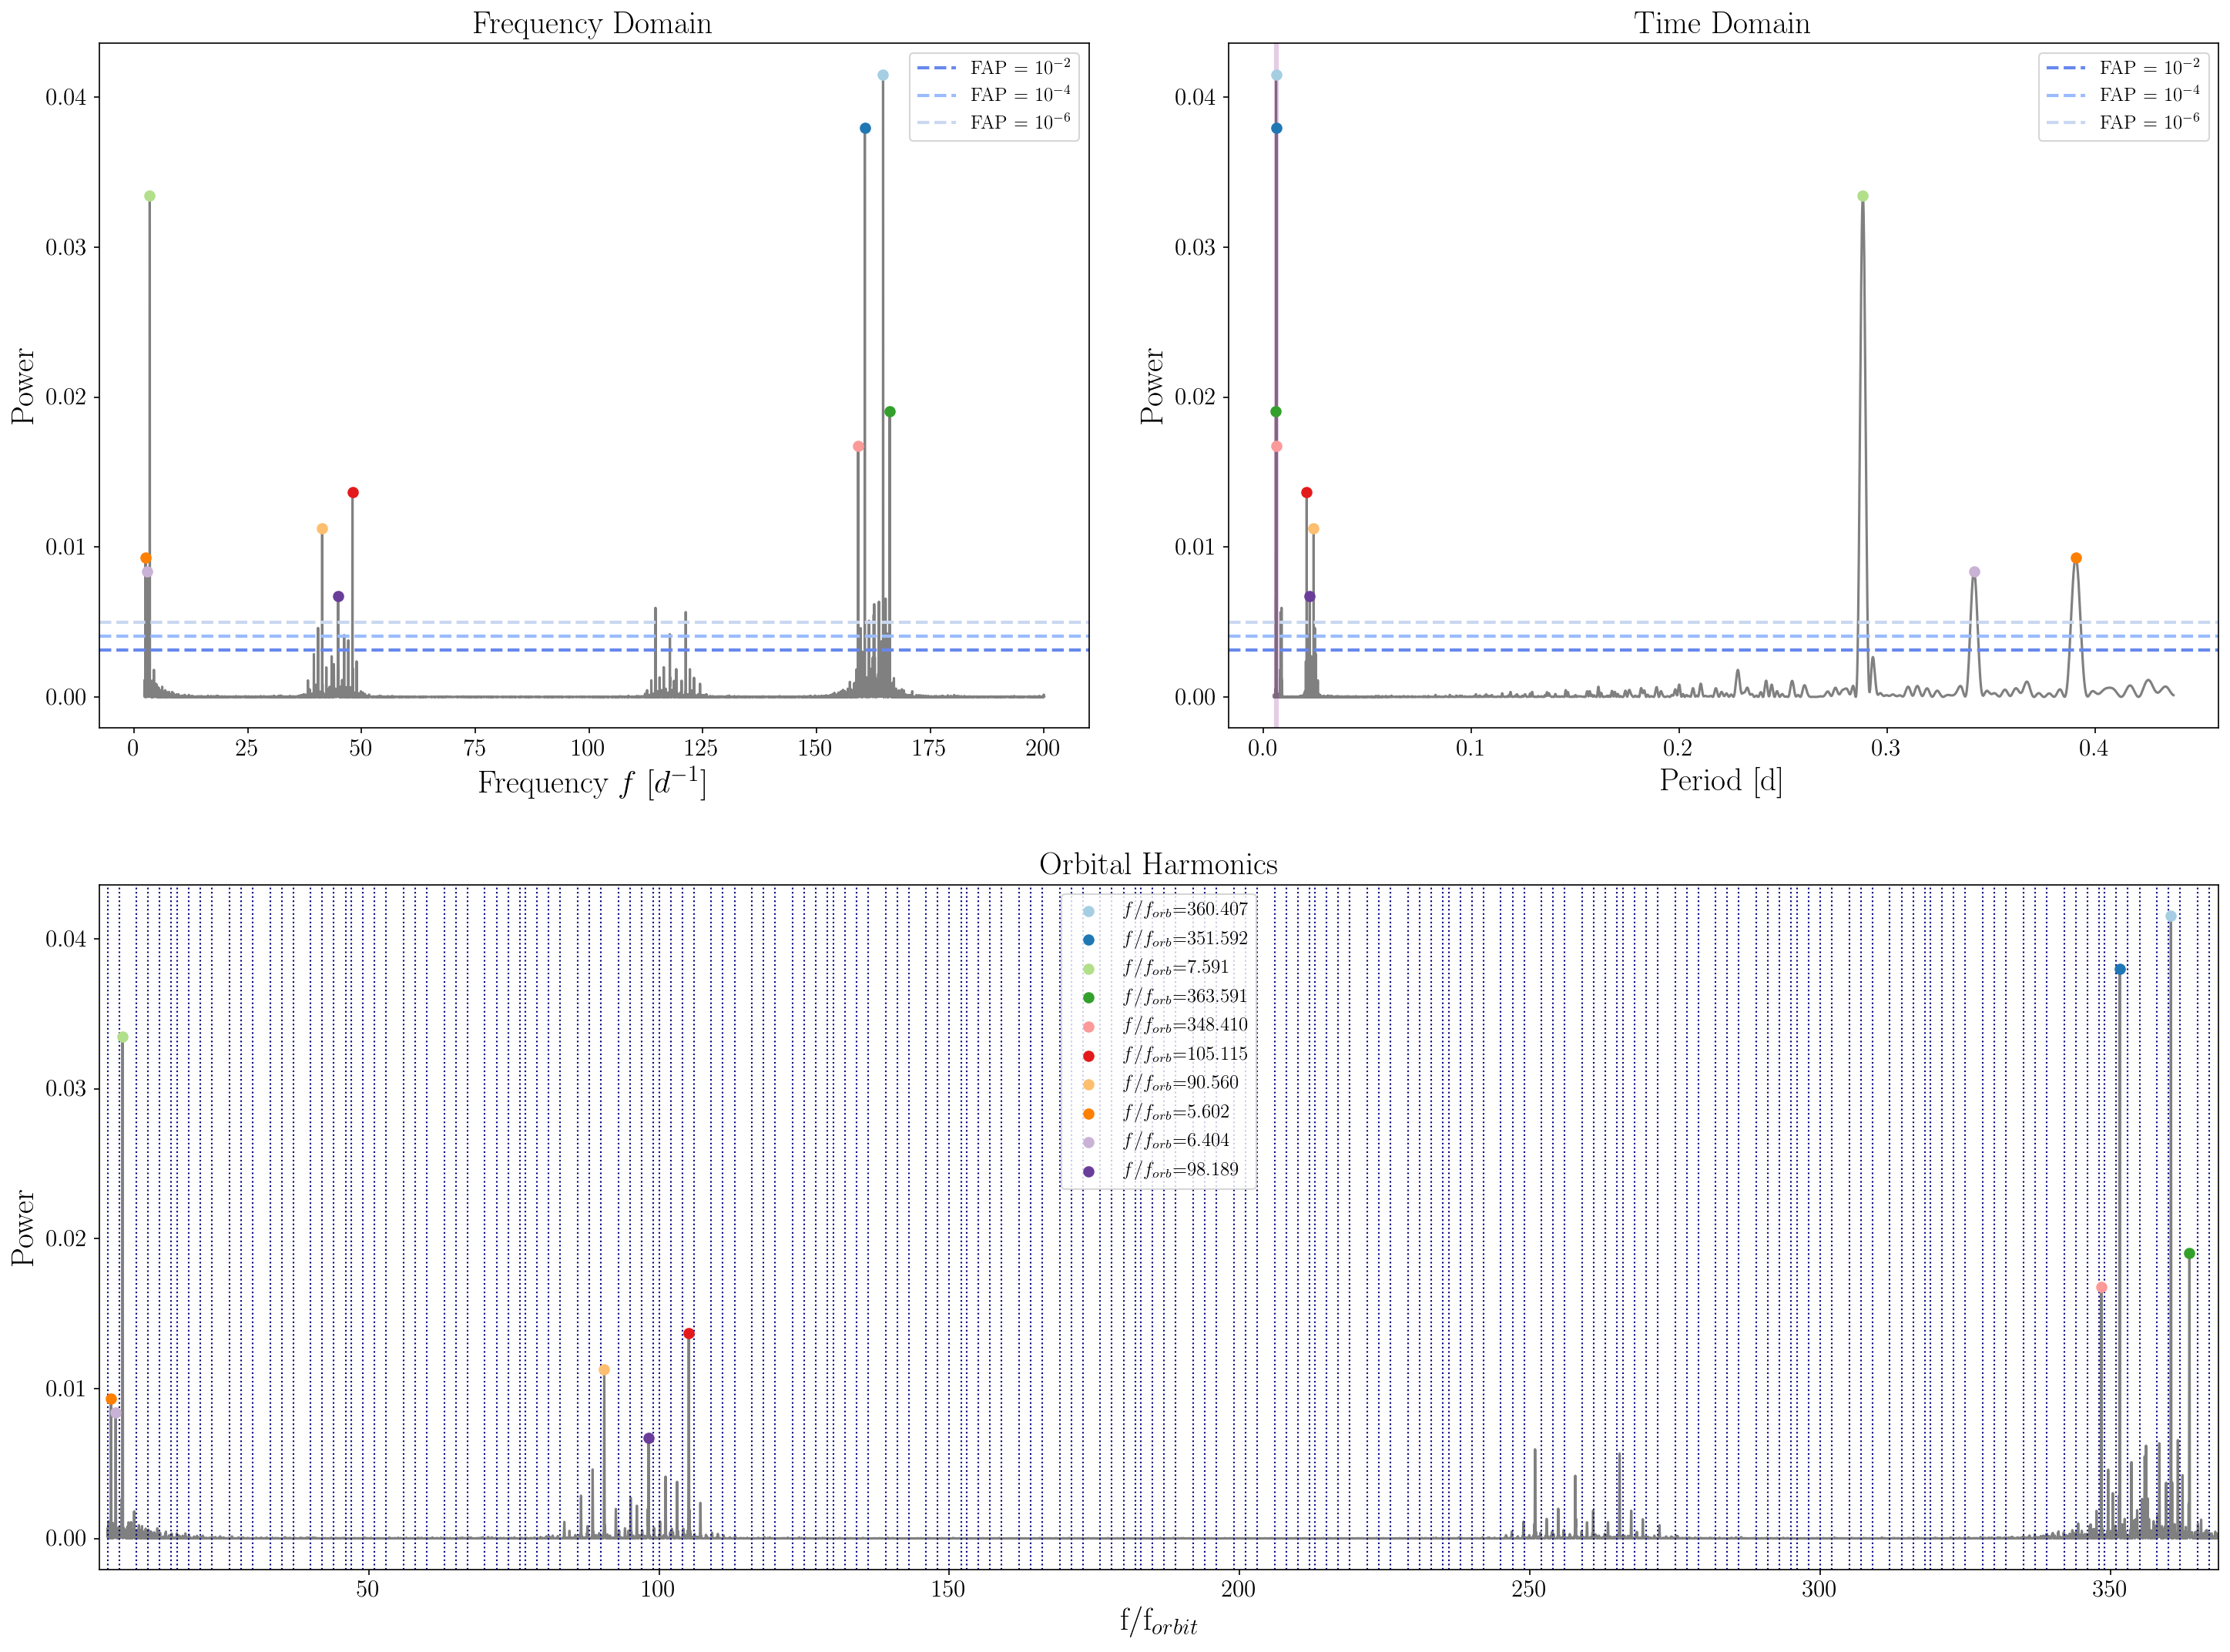

In [33]:
freq_osc_0, power_osc_0 = detect_oscillations(x_oot, y_oot, ls_res, None)

## Iterative Process to Search for New Oscillation Frequencies

Some Useful Plotting Functions

In [34]:
cdict = {
    "lc": "cornflowerblue", 
    "gp_pred": "orange", 
    "pc": "green", 
    "osc": "crimson", 
    "zoom_models": "purple", 
    "zoom_osc": "wheat"}

legend_fsize = 22

def evaluate_model(flux, best_model, map_solution, i):
    print("\n-----> Obtaining Maximum a Posteriori Parameters ")
    
    with best_model:
        gp_pred = xo.eval_in_model(best_model.gp_lc.predict(), map_solution) + map_solution["mean_lc"]
        lc = xo.eval_in_model(best_model.model_lc, map_solution)
        osc, pc = xo.eval_in_model([best_model.osc, best_model.phase_curve], map_solution)
        
    model_residuals = flux - lc - pc - osc #- gp_pred 
    
    x_fold = (best_model.x - map_solution["t0"]) % map_solution["period"] / map_solution["period"]
    inds = np.argsort(x_fold)    
    
    fig = plt.figure(figsize=(32,30))
    fig.subplots_adjust(hspace=0.8)
    ax00 = fig.add_subplot(421)
    ax01 = fig.add_subplot(422)
    ax10 = fig.add_subplot(423)
    ax11 = fig.add_subplot(424)
    ax20 = fig.add_subplot(425)
    ax21 = fig.add_subplot(426)
    ax30 = fig.add_subplot(414)
        
    ax00.plot(best_model.x, best_model.y, "k.", alpha=0.5, label = 'Observed LC')
    ax00.plot(best_model.x, lc, c=cdict["lc"], label = 'Eclipse Model')
    ax00.plot(best_model.x, gp_pred, c=cdict["gp_pred"], lw=2, label = 'GP Model')
    ax00.plot(best_model.x, pc, c=cdict["pc"], label = 'Phase Curve Model')
    ax00.plot(best_model.x, osc, c=cdict["osc"], label = 'Oscillation Model')
    ax00.legend(fontsize=legend_fsize, loc='lower left')
    ax00.set_title("MAP Model LC",fontsize=30)
    ax00.set(
        xlabel="Time - %i [BKJD days]"%kepler_tref, 
        ylabel="Raw flux [ppt]"
    );
        
    ax01.plot(best_model.x, osc, c=cdict["osc"], alpha=0.8,label = "Oscillation Model")
    ax01.plot(best_model.x, model_residuals, c='lightsteelblue', alpha=0.8, label = 'Residuals = Observed LC - (Eclipse Model + PC Model + Osc. Model)')
    ax01.plot(best_model.x, gp_pred, marker='.', c=cdict["gp_pred"], alpha=0.6, label = "GP Model")
    ax01.legend(fontsize=legend_fsize)
    ax01.set(
        xlabel="Time - %i [BKJD days]"%kepler_tref,
        ylabel="Raw Flux [ppt]"
    );
    ax01.set_title("Light Curve Residuals",fontsize=30)
        
    ax10.plot(best_model.x, best_model.y, "k.", alpha=0.2, label = 'Observed LC')
    ax10.plot(best_model.x, osc, c=cdict["osc"], label = 'Oscillations Model')
    ax10.plot(best_model.x, pc, c=cdict["pc"], lw=2, label = 'Phase Curve Model')
    ax10.plot(best_model.x, gp_pred, c=cdict["gp_pred"], label = 'GP Model')
    ax10.axvspan(min(best_model.x), min(best_model.x)+2, facecolor=cdict["zoom_models"], alpha=0.1, label='Zoomed Region')
    ax10.legend(fontsize=legend_fsize)
    ax10.set_title("MAP Model LC",fontsize=30)
    ax10.set(
        xlim = (best_model.x.min(), best_model.x.max()), 
        ylim = (-10, 15), 
        xlabel="Time - %i [BKJD days]"%kepler_tref, 
        ylabel="Raw flux [ppt]"
    );

    ax11.plot(best_model.x, best_model.y, "k.", alpha=0.2, label = 'Observed LC')
    ax11.plot(best_model.x, osc, c=cdict["osc"], lw=2, label = 'Oscillations Model')
    ax11.plot(best_model.x, pc, c=cdict["pc"], lw=2, label = 'Phase Curve Model')
    ax11.plot(best_model.x, gp_pred, c=cdict["gp_pred"], lw=2, label = 'GP Model')
    ax11.axvspan(min(best_model.x), min(best_model.x)+2, facecolor=cdict["zoom_models"], alpha=0.1, label='Zoomed Region')
    ax11.legend(fontsize=legend_fsize)
    ax11.set_title("MAP Model LC (Zoomed-in)",fontsize=30)
    ax11.set(
        xlim = (best_model.x.min(),best_model.x.min()+2),
        ylim = (-10, 15), 
        xlabel="Time - %i [BKJD days]"%kepler_tref,
        ylabel="Raw flux [ppt]"
    );
        
    ax20.plot(best_model.x, best_model.y - lc - pc - gp_pred, "k.", alpha=0.2, label = 'Observed LC - (Eclipse Model + PC Model + GP. Model)') #
    ax20.plot(best_model.x, osc, c=cdict["osc"], label = "Oscillations Model")
    ax20.axvspan(min(best_model.x), min(best_model.x)+1, facecolor=cdict["zoom_osc"], alpha=0.3,label='Zoomed Region')
    ax20.legend(fontsize=legend_fsize, loc="upper right")
    ax20.set_title("Oscillation Model", fontsize=30)
    ax20.set(
        xlabel="Time - %i [BKJD days]"%kepler_tref,
        ylabel="Raw Flux [ppt]",
        xlim = (best_model.x.min(), best_model.x.max())
    );
        
    ax21.plot(best_model.x, best_model.y - lc - pc - gp_pred, "k.", alpha=0.2, label = 'Observed LC - (Eclipse Model + PC Model + GP Model)') #
    ax21.plot(best_model.x, osc, c=cdict["osc"], label = "Oscillations Model")
    ax21.axvspan(best_model.x.min(),best_model.x.min()+1, facecolor=cdict["zoom_osc"], alpha=0.1, label='Zoomed Region')
    ax21.legend(fontsize=legend_fsize,loc="upper right")
    ax21.set_title("Oscillation Model (Zoomed-in)", fontsize=30)
    ax21.set(
        xlim = (best_model.x.min(),best_model.x.min()+1),
        xlabel="Time - %i [BKJD days]"%kepler_tref,
        ylabel="Raw Flux [ppt]",
    );
            
    ax30.plot(x_fold[inds], best_model.y[inds] - gp_pred[inds] - osc[inds], "k.", alpha=0.2, label = 'Observed LC - (GP Model + Oscillation Model)')
    ax30.plot(x_fold[inds] - 1, best_model.y[inds] - gp_pred[inds] - osc[inds], "k.", alpha=0.2)
    ax30.plot(x_fold[inds], lc[inds], c = cdict["lc"], lw=2, label = "Eclipse Model")
    ax30.plot(x_fold[inds] - 1, lc[inds], c = cdict["lc"], lw=2)
    ax30.plot(x_fold[inds], pc[inds], c = cdict["pc"], lw=2)
    ax30.plot(x_fold[inds] - 1, pc[inds], c = cdict["pc"], lw=2, label = "Phase Curve Model")
    ax30.legend(fontsize=legend_fsize)
    ax30.set_title("Detrended Light Curve", fontsize=30)
    ax30.set(
        xlim=(-1, 1), 
        xlabel = "Orbital Phase", 
        ylabel = "De-trended flux [ppt]"
    );
        
    fig.tight_layout()
    fig.savefig(fpath_chunk+"map/map_model_"+i+".png")
        
    plt.pause(0.05); 
    plt.close("all")
    
    return model_residuals, osc, gp_pred, pc, lc

In [35]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

def add_sub_axes(axis, rect):
    fig = axis.figure
    left, bottom, width, height = rect
    trans = axis_to_fig(axis)
    figleft, figbottom = trans((left, bottom))
    figwidth, figheight = trans([width,height]) - trans([0,0])
    
    return fig.add_axes([figleft, figbottom, figwidth, figheight])

def axis_to_fig(axis):
    fig = axis.figure
    def transform(coord):
        return fig.transFigure.inverted().transform(
            axis.transAxes.transform(coord))
    return transform

def pg_of_model(time, flux, osc, gp_pred, pc, lc, i=None):
    
    model_residuals_without_GP = flux - lc - pc - osc
    model_residuals_with_GP = flux - lc - pc - osc - gp_pred 
    
    pg_residuals_with_GP = ls_estimator(time, model_residuals_with_GP, freq_grid, npeaks)
    pg_residuals_no_GP = ls_estimator(time, model_residuals_without_GP, freq_grid, npeaks)
    pg_osc_model = ls_estimator(time, osc, freq_grid, npeaks)
    pg_gp_model = ls_estimator(time, gp_pred, freq_grid, npeaks)
    
    #For zoom-in plots
    xmin_sf, xmax_sf = min(freq_grid), 10
    xmin_hf, xmax_hf = 35, 55
    ymax1 = max(pg_residuals_no_GP["periodogram"][1])/2
    ymax2 = max(pg_osc_model["periodogram"][1])/2
    
    fig = plt.figure(figsize=(40,12))
    fig.subplots_adjust(wspace=0.2)
    ax1 = fig.add_subplot(121) #The first one being the number of rows in the grid, the second one being the number of columns in the grid and the third one being the position at which the new subplot must be placed.
    ax2 = fig.add_subplot(122)
    
    zoom1_sf = add_sub_axes(ax1, [0.5, 0.55, 0.45, 0.25])
    zoom1_hf = add_sub_axes(ax1, [0.5, 0.15, 0.45, 0.25])
    zoom2_sf = add_sub_axes(ax2, [0.5, 0.55, 0.45, 0.25])
    zoom2_hf = add_sub_axes(ax2, [0.5, 0.15, 0.45, 0.25])
    
    axes = [ax1, ax2]
    zoom1 = [ax1, zoom1_sf, zoom1_hf]
    zoom2 = [ax2, zoom2_sf, zoom2_hf]
    
    for idx,z in enumerate(zoom1):
        z.plot(pg_residuals_no_GP["periodogram"][0],pg_residuals_no_GP["periodogram"][1], c='grey', alpha=0.8, label = 'Residuals (GP not subtracted)')
        z.plot(pg_residuals_with_GP["periodogram"][0], pg_residuals_with_GP["periodogram"][1], c='orchid', lw = 1.5, label = 'Residuals (GP subtracted)') 
        
        if idx == 0:
            z.axvspan(xmin_sf, xmax_sf, color='yellowgreen', hatch='.', alpha = 0.8, fill=False)
            z.axvspan(xmin_hf, xmax_hf, color='cornflowerblue', hatch='/', alpha = 0.8, fill=False)
            z.legend(fontsize=20)
            z.set_xlabel(r"Frequency $f$ [$d^{-1}$]", size=30); 
            z.set_ylabel("Power", size=30)
            z.set_title("LS Periodogram of the Model Residuals", fontsize=36, y=1.03);
            
        elif idx == 1: 
            z.axvspan(xmin_sf, xmax_sf, color='yellowgreen', hatch='.', alpha = 0.3, fill=False)
            z.set(xlim=(xmin_sf, xmax_sf), ylim=(0,ymax1))
            z.set_xlabel(r"Frequency $f$ [$d^{-1}$]", size=15); 
            z.set_ylabel("Power", size=15)
            z.set_title(r"Zoomed-in ($x_{lim} = [%0.02f, %i]$, $y_{lim}=[%i,%0.4f]$)" %(xmin_sf, xmax_sf, 0, ymax1), fontsize=20, y=1.02)
        else:
            z.axvspan(xmin_hf, xmax_hf, color='cornflowerblue', hatch='/', alpha = 0.3, fill=False)
            z.set(xlim=(xmin_hf, xmax_hf), ylim=(0, ymax1)) 
            z.set_xlabel(r"Frequency $f$ [$d^{-1}$]", size=15); 
            z.set_ylabel("Power", size=15)
            z.set_title(r"Zoomed-in ($x_{lim} = [%i, %i]$, $y_{lim}=[%i,%0.4f]$)" %(xmin_hf, xmax_hf, 0, ymax1), fontsize=20, y=1.02) 
        
    
    for idx,z in enumerate(zoom2):
        z.plot(pg_osc_model["periodogram"][0], pg_osc_model["periodogram"][1], c=cdict["osc"], label = "Osc. Model")
        z.plot(pg_gp_model["periodogram"][0], pg_gp_model["periodogram"][1], c=cdict["gp_pred"], label = "GP. Model")
        
        if idx == 0:
            z.axvspan(xmin_sf, xmax_sf, color='yellowgreen', hatch='.', alpha = 0.8, fill=False)
            z.axvspan(xmin_hf, xmax_hf, color='cornflowerblue', hatch='/', alpha = 0.8,  fill=False)
            z.set_title("LS Periodogram of the Oscillation and GP Models", fontsize=36, y=1.03);
            z.set_xlabel(r"Frequency $f$ [$d^{-1}$]", size=30); 
            z.set_ylabel("Power", size=30)
            z.legend(fontsize=20)
        elif idx == 1: 
            z.axvspan(xmin_sf, xmax_sf, color='yellowgreen', hatch='.', alpha = 0.3, fill=False)
            z.set(xlim=(xmin_sf, xmax_sf), ylim=(0, ymax2))
            z.set_xlabel(r"Frequency $f$ [$d^{-1}$]", size=15); 
            z.set_ylabel("Power", size=20)
            z.set_title(r"Zoomed-in ($x_{lim} = [%0.02f, %i]$, $y_{lim}=[%i,%0.4f]$)" %(xmin_sf, xmax_sf, 0, ymax2), fontsize=20, y=1.02)
        else:
            z.axvspan(xmin_hf, xmax_hf, color='cornflowerblue', hatch='/', alpha = 0.3, fill=False)
            z.set(xlim=(xmin_hf, xmax_hf), ylim=(0, ymax2))
            z.set_xlabel(r"Frequency $f$ [$d^{-1}$]", size=15); 
            z.set_ylabel("Power", size=20)
            z.set_title(r"Zoomed-in ($x_{lim} = [%i, %i]$, $y_{lim}=[%i,%0.4f]$)" %(xmin_hf, xmax_hf, 0, ymax2), fontsize=20,y=1.02) 
        
            
    if i is not None: 
        fig.tight_layout()
        fig.savefig(fpath_chunk+"map/pg_models_"+i+".png")
        
    plt.pause(0.05); plt.close("all")
    
    return pg_osc_model, pg_gp_model

### Define `exoplanet` Model
<a class="anchor" id="section_1_5_3"></a>

In [36]:
def build_model(time, flux, map_pr, osc_freqs, mask=None):
    
    print("\n----->  Printing Best Initial Guesses\n")
    print("P = %0.04f d" %map_pr['period'])
    print("t0 = %0.06f d" %map_pr['t0'])
    print("b = %0.04f" % map_pr['b'])
    print("Transit Jitter and GP Parameters:\n *sigma = %0.04f\n *S_tot = %0.04f\n *ell = %0.04f" %(map_pr['sigma_lc'], map_pr['S_tot_lc'], map_pr['ell_lc']))
    print("Nº of Oscillation Frequencies Used: %s" %(len(osc_freqs)))
    
    if mask is None:
        mask = np.ones_like(x, dtype=bool)
    
    with pm.Model() as model:
        
        print("\n----->  Initializing the Model\n")
        # Systemic parameters
        u1 = xo.QuadLimbDark("u1")
        u2 = xo.QuadLimbDark("u2")

        # Parameters describing the primary: could include priors based on isochrones or similar
        M1 = pm.Lognormal("M1", mu=0.0, sigma=10.0)
        R1 = pm.Lognormal("R1", mu=0.0, sigma=10.0) 

        # Secondary ratios
        k = pm.Lognormal("k", mu=0.0, sigma=10.0)  # radius ratio R2/R1
        q = pm.Lognormal("q", mu=0.810, sigma=0.01)  # mass ratio M2/M1
        s = pm.Lognormal("s", mu=np.log(0.5), sigma=10.0)  # surface brightness ratio S2/S1

        # Parameters describing the orbit
        b = xo.ImpactParameter("b", ror=k, testval=map_pr['b'])
        period = pm.Lognormal("period", mu=np.log(map_pr['period']), sigma=1.0) #np.log(lit_period)
        t0 = pm.Normal("t0", mu=map_pr['t0'], sigma=1.0) #lit_t0

        # Parameters describing the eccentricity: ecs = [e * cos(ω), e * sin(ω)]
            # e sin ω - the radial component of eccentricity. 
                # Were e and ω to enter the training separately, problems would arise at small
                # eccentricities; e.g., as gets smaller, ω becomes indeterminate. Furthermore, 
                # the orthogonalized components in ω and e cos ω have distinct effects on the shape
                # of the LC. Radial eccentricity e sin ω is directly proportional to the
                # ratio (d2 − d1)/(d2 + d1) of the durations both minima. 
            # e cos ω - Tangential component of eccentricity. The tangential orthogonalized component e*cos ω
                # is directly related to the displacement of the minima. This component is a first order
                # effect, whereas the eclipse width change is a 2nd-order effect.
        # From  https://arxiv.org/pdf/0807.1724.pdf: 
            # 1) e and ω determine the separation between the eclipses and also the ratio of their widths.  
            # 2) Ranges of values for esinw and ecosw for detached EBs: table 1 in https://arxiv.org/pdf/0807.1724.pdf
        # Also https://gallery.exoplanet.codes/en/latest/tutorials/eb/#a-note-about-eccentricities:
        # And also from Andrew 2016 (https://iopscience.iop.org/article/10.1088/0004-637X/808/2/126/pdf):
            #"As explained in Van Eylen & Albrecht (2015), directly exploring e and ω biases the eccentricity 
            # to higher values owing to the cutoff at zero, while sampling uniformly in √esin(ω) and √ecos(ω) 
            # between -1 and 1 is unbiased and still provides uniform sampling in e and ω
            #(see Lucy & Sweeney 1971;Ford 2006; Anderson et al. 2011; Eastman et al. 2013, for more detailed
            # discussions of this issue)"
        
        ecosw = 0.25 * np.pi * (2 * (second_phase + lit_period) / lit_period - 1)
        ecs = xo.UnitDisk("ecs", testval=np.array([ecosw, 0.0]))
        ecc = pm.Deterministic("ecc", tt.sqrt(tt.sum(ecs ** 2)))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))

        # Build the orbit
        R2 = pm.Deterministic("R2", k * R1)
        M2 = pm.Deterministic("M2", q * M1)
        orbit = xo.orbits.KeplerianOrbit(
            period=period,
            t0=t0,
            ecc=ecc,
            omega=omega,
            b=b,
            r_star=R1,
            m_star=M1,
            m_planet=M2,
        )

        # Track some other orbital elements
        pm.Deterministic("incl", orbit.incl)
        pm.Deterministic("a", orbit.a)
        pm.Deterministic("rho_circ", orbit.rho_star) #track implied density

        # Set up the LC model
        lc = xo.SecondaryEclipseLightCurve(u1, u2, s)
        model_lc = 1e3 * lc.get_light_curve(orbit=orbit, r=R2, t=time[mask])[:, 0]

        # Oscillation model using frequencies from periodogram
        arg = osc_freqs[None, :] * time[mask, None]
        X = np.concatenate([np.cos(2 * np.pi * arg), np.sin(2 * np.pi * arg),], axis=1)
        
#         w0 = np.linalg.lstsq(X, y[mask])[0]
#         w = pm.Normal("w", mu=0.0, sigma=10.0, shape=len(w0), testval=w0)
#         osc = tt.dot(X, w)
#         osc = tt.zeros(mask.sum())
        
        # Phase curve: mixture of harmonics of the period. 6th order seems to work well 
        # based on trial and error
        phi = ((time[mask] - t0) / period) % 1.0
        n_expand = 6
        
        comps = tt.stack([
            tt.sin(2 * (n + 1) * np.pi * phi)
            for n in range(n_expand)
        ] + [
            tt.cos(2 * (n + 1) * np.pi * phi)
            for n in range(n_expand)
        ], axis=1)
#        amps = pm.Normal("amps", sigma=100.0, shape=2 * n_expand)
#        phase_curve = tt.dot(amps, comps)
        
        # Transit jitter & GP parameters
        sigma_lc = pm.InverseGamma("sigma_lc", testval = map_pr['sigma_lc'], **xo.estimate_inverse_gamma_parameters(0.1, 2.0))
        S_tot_lc = pm.InverseGamma("S_tot_lc", testval = map_pr['S_tot_lc'], **xo.estimate_inverse_gamma_parameters(1.0, 5.0))
        ell_lc = pm.InverseGamma("ell_lc", testval = map_pr['ell_lc'], **xo.estimate_inverse_gamma_parameters(1.0, 5.0)) #0.1,5.0
        kernel_lc = xo.gp.terms.SHOTerm(S_tot=S_tot_lc, w0=2 * np.pi / ell_lc, Q=1.0/np.sqrt(2))#3) 
        gp_lc = xo.gp.GP(kernel_lc, time[mask], tt.zeros(mask.sum())** 2 + sigma_lc**2)

#       def mean_model(t):
#           return mean_lc + osc + phase_curve + model_lc(t)
        
        D = tt.concatenate((X, comps, tt.ones((mask.sum(), 1))), axis=1)
        DT = D.T
        DTD = tt.dot(DT, gp_lc.apply_inverse(DT.T)) + 0.01**2 * tt.eye(2 * (len(osc_freqs) + n_expand) + 1)
        
        #DTD_det_print = tt.printing.Print("DTD_det")(tt.nlinalg.det(DTD))
        DTy = tt.dot(DT, gp_lc.apply_inverse((flux[mask] - model_lc)[:, None]))
        factor = tt.slinalg.cholesky(DTD)
        weights = tt.slinalg.solve_upper_triangular(factor.T, tt.slinalg.solve_lower_triangular(factor, DTy))[:, 0]
        #weights = tt.slinalg.solve(DTD, DTy)[:, 0]
        w = pm.Deterministic("w", weights[:2 * len(osc_freqs)])
        
        osc = tt.dot(X, w)
        amps = pm.Deterministic("amps", weights[2 * len(osc_freqs):2 * n_expand + 2 *len(osc_freqs)])
        phase_curve = tt.dot(comps, amps)
        mean_lc = pm.Deterministic("mean_lc", weights[-1]) 
        
#       # Condition the light curve model on the data
#         gp_lc = xo.gp.GP(
#             kernel_lc, x[mask], tt.zeros(mask.sum()) ** 2 + sigma_lc ** 2, mean=mean_model
#         )
        
        gp_lc.marginal("obs_lc", observed=flux[mask] - tt.dot(D, weights) - model_lc)
        pm.Deterministic("gp_pred", gp_lc.predict())

        # Optimize the logp to obtain the maximum a posteriori parameters given the simuated dataset
        map_soln = model.test_point
        map_soln = xo.optimize(map_soln, vars=[R1, k, s, b, u1, u2])
        #map_soln = xo.optimize(map_soln, [amps])
        #map_soln = xo.optimize(map_soln, [w])
        map_soln = xo.optimize(map_soln, vars=[S_tot_lc, ell_lc, sigma_lc])
        map_soln = xo.optimize(map_soln) 

        model.osc = osc
        model.phase_curve = phase_curve
        model.gp_lc = gp_lc
        model.model_lc = model_lc
        model.x = time[mask]
        model.y = flux[mask]

    return model, map_soln

In [43]:
def sigma_clip(time, flux, map_pr, osc_freqs):
    mask = np.ones(len(time), dtype=bool)
    num = len(mask)

    for i in range(10):
        model, map_soln = build_model(time, flux, map_pr, osc_freqs, mask)

        with model:
            mdl = xo.eval_in_model(
                model.model_lc + model.gp_lc.predict() + model.osc, map_soln
            )

        resid = flux[mask] - mdl
        sigma = np.sqrt(np.median((resid - np.median(resid)) ** 2))
        mask[mask] = np.abs(resid - np.median(resid)) < 7 * sigma
 
        print("Sigma clipped {0} light curve points".format(num - mask.sum()))
        
        if num == mask.sum():
            break
        num = mask.sum()

    return model, map_soln, mask

Loop will stop when there are no more frequencies with FAP $<10^{-2}$


               ITERATION 1
*******************************************

----->  Printing Best Initial Guesses

P = 2.1891 d
t0 = 121.135787 d
b = 1.0000
Transit Jitter and GP Parameters:
 *sigma = 1.0000
 *S_tot = 1.0000
 *ell = 1.0000
Nº of Oscillation Frequencies Used: 10

----->  Initializing the Model



optimizing logp for variables: [u2, u1, b, k, s, R1]


message: Desired error not necessarily achieved due to precision loss.
logp: -15286501.172868043 -> -9489277.292104298
optimizing logp for variables: [sigma_lc, ell_lc, S_tot_lc]


message: Desired error not necessarily achieved due to precision loss.
logp: -9489277.292104298 -> -7555.713836735446
optimizing logp for variables: [ell_lc, S_tot_lc, sigma_lc, ecs, t0, period, b, s, q, k, R1, M1, u2, u1]


message: Desired error not necessarily achieved due to precision loss.
logp: -7555.713836735446 -> -7555.713836735446


Sigma clipped 2986 light curve points

----->  Printing Best Initial Guesses

P = 2.1891 d
t0 = 121.135787 d
b = 1.0000
Transit Jitter and GP Parameters:
 *sigma = 1.0000
 *S_tot = 1.0000
 *ell = 1.0000
Nº of Oscillation Frequencies Used: 10

----->  Initializing the Model



optimizing logp for variables: [u2, u1, b, k, s, R1]


message: Desired error not necessarily achieved due to precision loss.
logp: -6310728.319380212 -> -158357.49392424448
optimizing logp for variables: [sigma_lc, ell_lc, S_tot_lc]


message: Desired error not necessarily achieved due to precision loss.
logp: -158357.49392424448 -> -5141.376656519034
optimizing logp for variables: [ell_lc, S_tot_lc, sigma_lc, ecs, t0, period, b, s, q, k, R1, M1, u2, u1]


message: Desired error not necessarily achieved due to precision loss.
logp: -5141.376656519034 -> -2629.606719121063


Sigma clipped 5102 light curve points

----->  Printing Best Initial Guesses

P = 2.1891 d
t0 = 121.135787 d
b = 1.0000
Transit Jitter and GP Parameters:
 *sigma = 1.0000
 *S_tot = 1.0000
 *ell = 1.0000
Nº of Oscillation Frequencies Used: 10

----->  Initializing the Model



optimizing logp for variables: [u2, u1, b, k, s, R1]


message: Optimization terminated successfully.
logp: -4164166.0754593997 -> -31962.341094937303
optimizing logp for variables: [sigma_lc, ell_lc, S_tot_lc]


message: Desired error not necessarily achieved due to precision loss.
logp: -31962.341094937303 -> -2304.661338757091
optimizing logp for variables: [ell_lc, S_tot_lc, sigma_lc, ecs, t0, period, b, s, q, k, R1, M1, u2, u1]


message: Desired error not necessarily achieved due to precision loss.
logp: -2304.661338757091 -> -1992.022104584262


Sigma clipped 0 light curve points

-----> Obtaining Maximum a Posteriori Parameters 


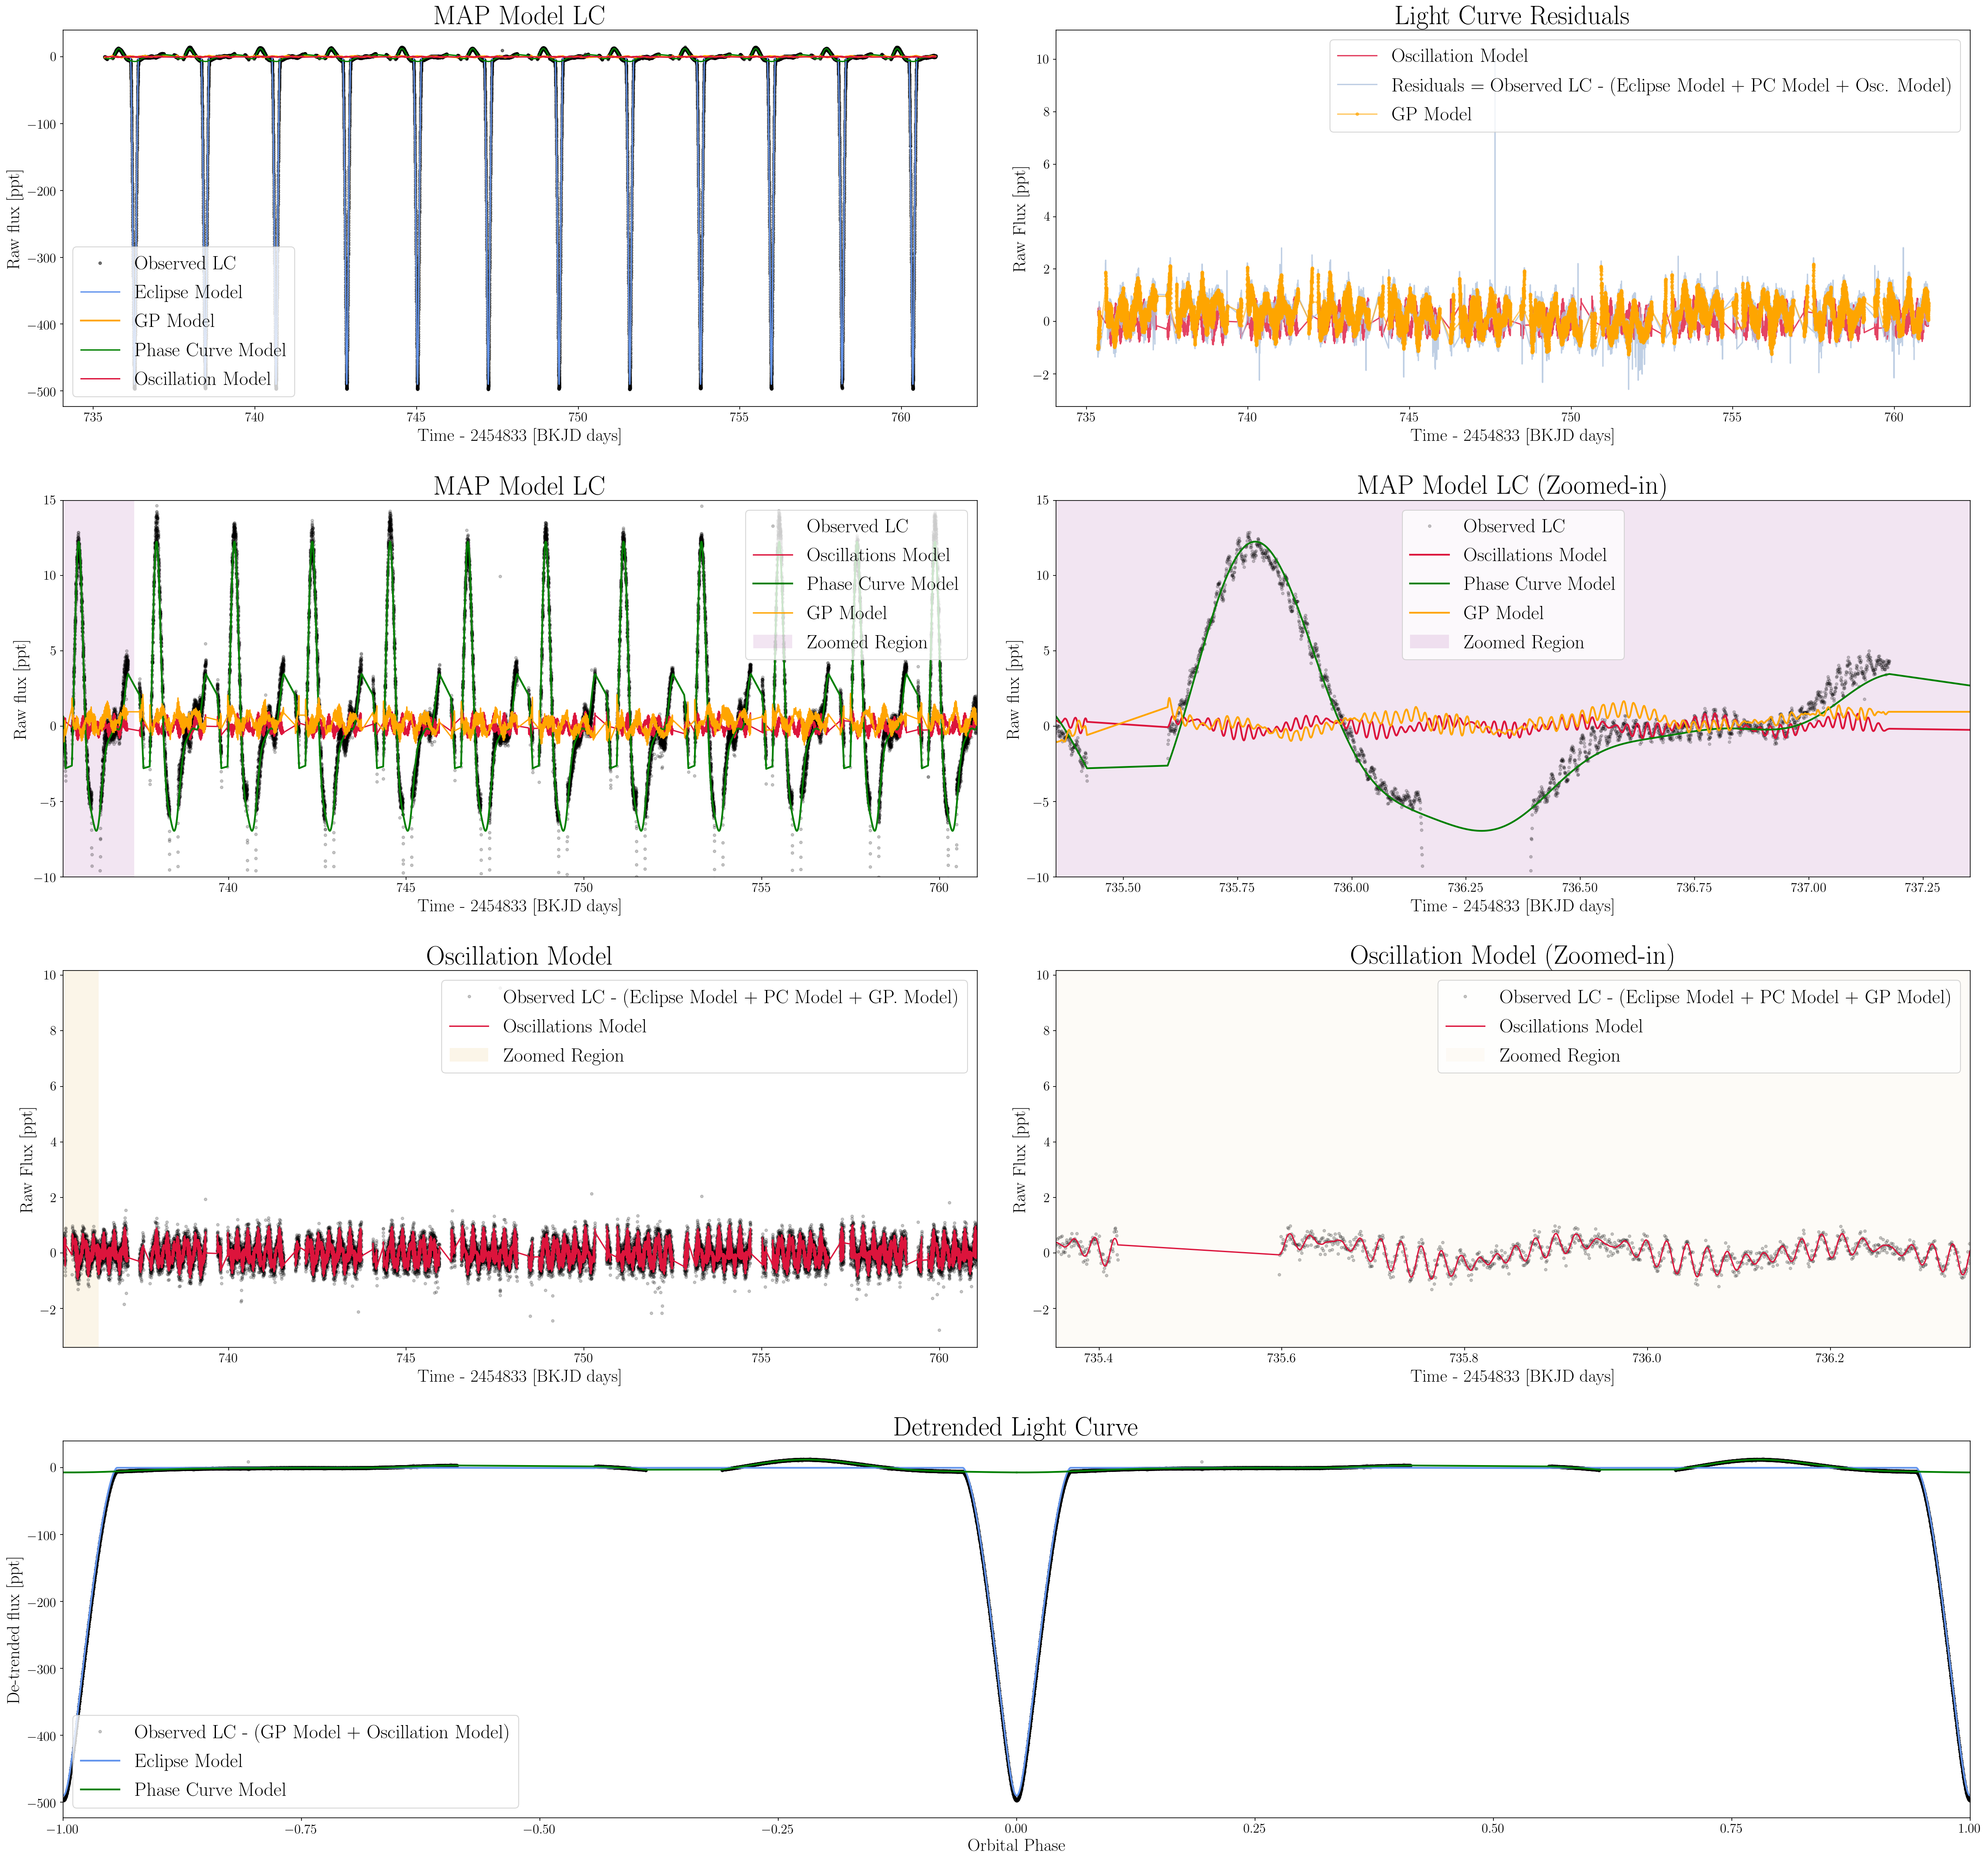

/Users/mbadenas/opt/anaconda3/envs/mit37_mkl/lib/python3.7/site-packages/ipykernel_launcher.py:102: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


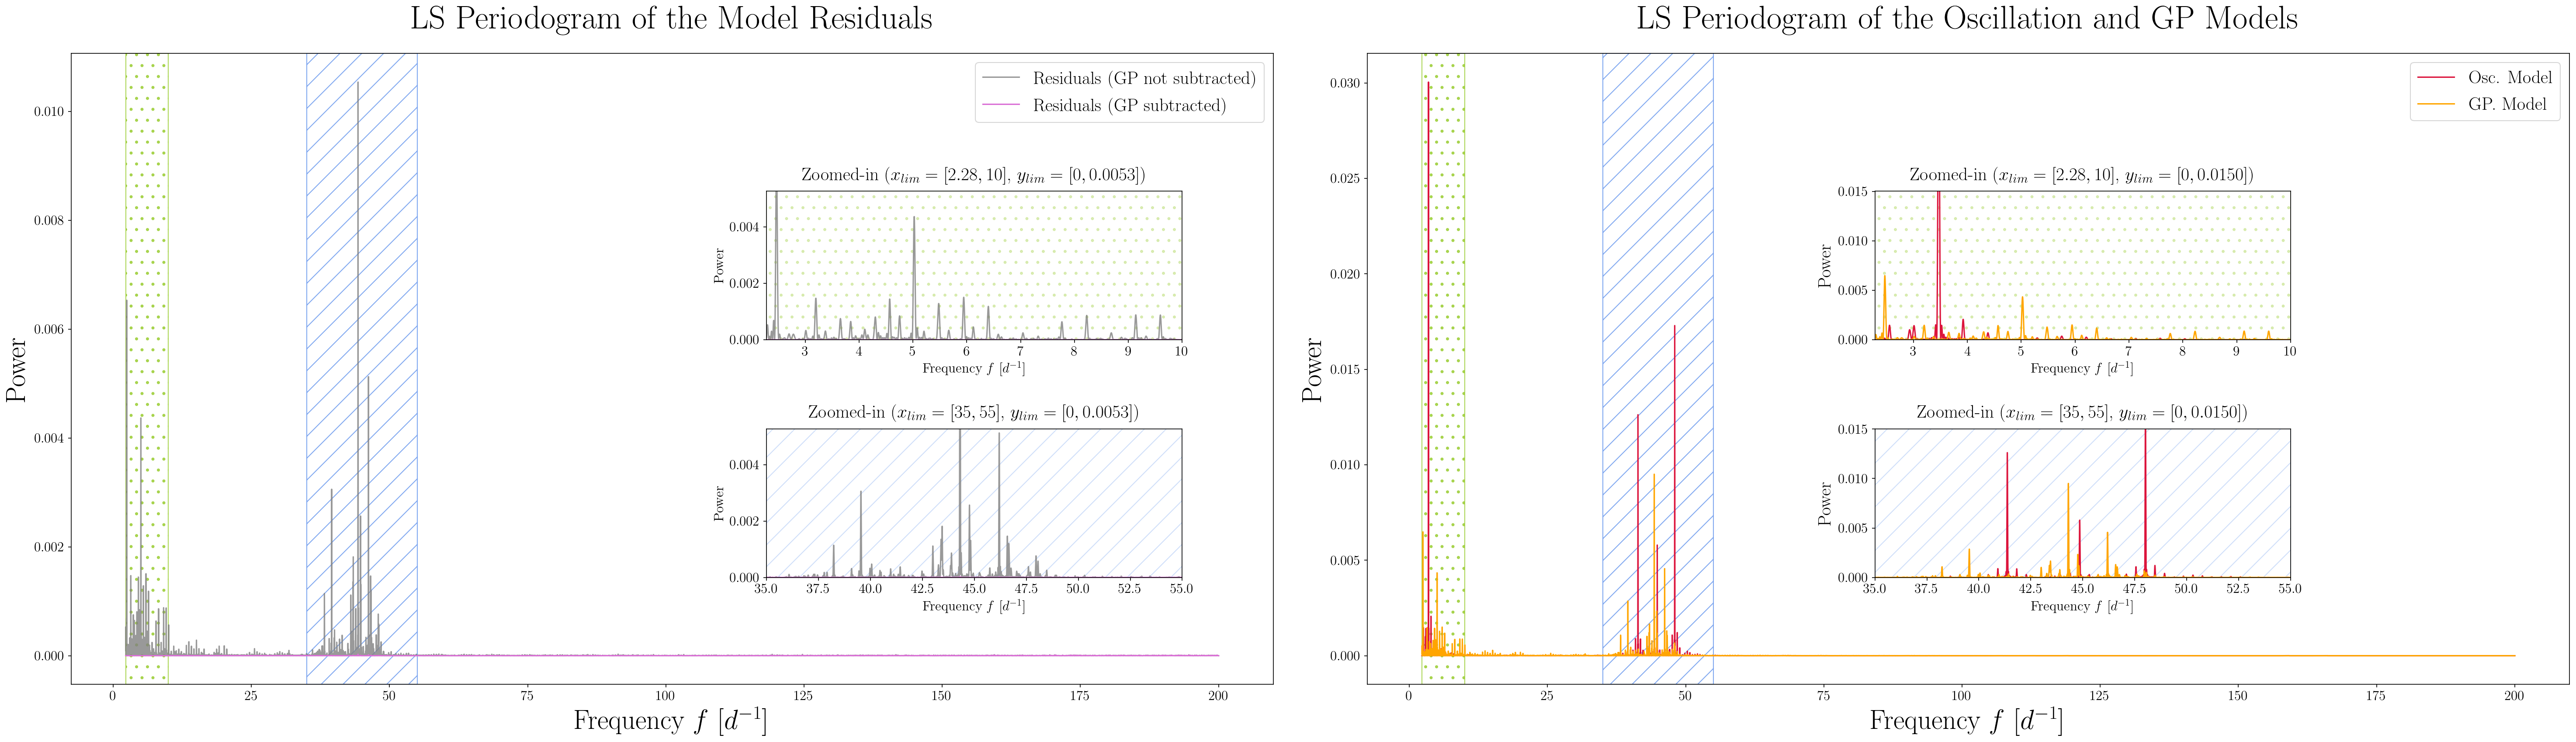


----->  Generating Periodogram of the Residuals
Best Frequency = 44.3064 d^-1
--> I have found 10 frequencies (max. allowed nº of freqs: 10)
--> I have found 10 frequencies with FAP > 10^-2
--> I have found 204 resonant frequencies in the periodogram!


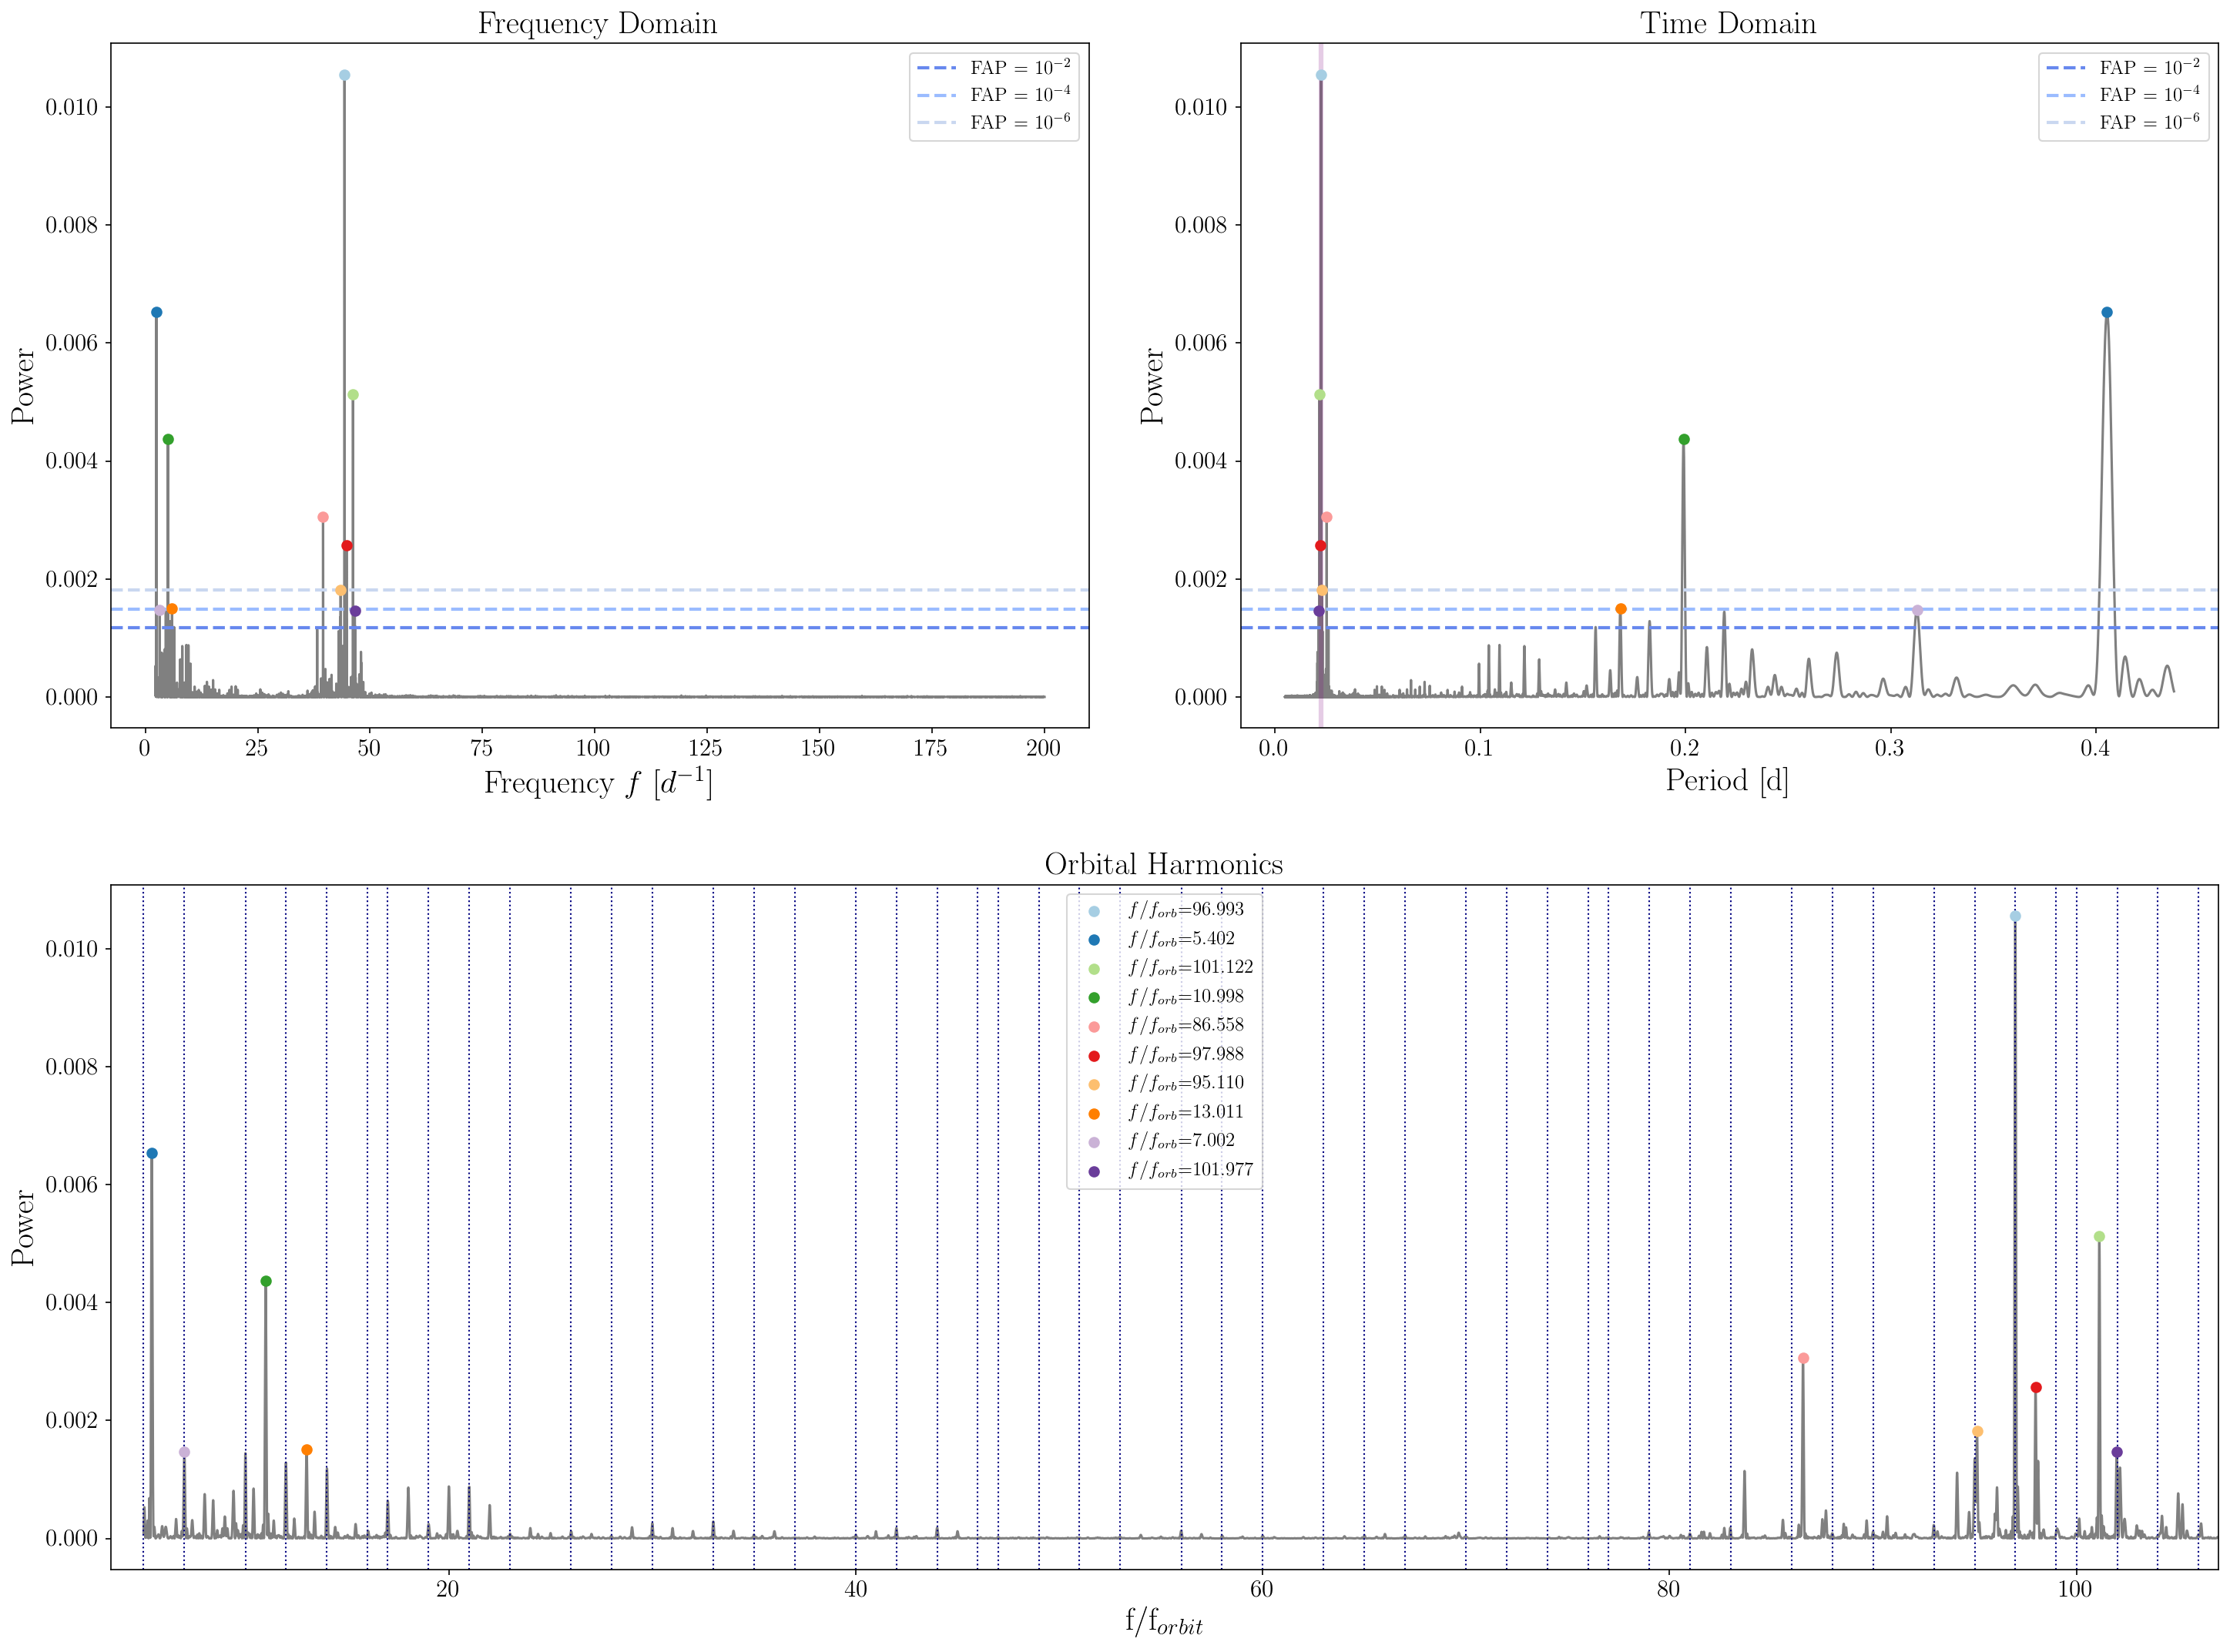


               ITERATION 2
*******************************************
Accumulated frequencies: 20

----->  Printing Best Initial Guesses

P = 2.1891 d
t0 = 121.135787 d
b = 1.0000
Transit Jitter and GP Parameters:
 *sigma = 1.0000
 *S_tot = 1.0000
 *ell = 1.0000
Nº of Oscillation Frequencies Used: 20

----->  Initializing the Model



optimizing logp for variables: [u2, u1, b, k, s, R1]


message: Desired error not necessarily achieved due to precision loss.
logp: -3288319.4023906277 -> -29988.67104403949


In [ ]:
plot_bool = True # False if you don't want to see MAP model plots. el 
model_results = {}
ls_results = {}

#Store MAP for the model components (to be improved: directly access them via best model)
osc_models = {} 
gp_models = {}
pc_models = {}
lc_models = {}
map_results = {}

xl = {}
yl = {}

for i in range(1,10): #10 is a conservative number (I doubt we'll ever get that far); this can also be redone with a while
    print("\n               ITERATION %s\n*******************************************" %i)
    if i == 1: 
        ls_results[i] = [freq_osc_0, power_osc_0] #initial freqs
        map_init = {
            'period': lit_period,
            't0': lit_t0,
            'b': 1.0, #   
            'sigma_lc': 1.0, 
            'S_tot_lc': 1.0, 
            'ell_lc': 1.0}  
        
        #Initialize the Model
        mod_i, map_i, mask_i = sigma_clip(x, y, map_init, freq_osc_0) 
        
        #Calculate model residuals & plot MAP
        residuals, best_osc, best_gp, best_pc, best_lc = evaluate_model(y[mask_i], mod_i, map_i, str(i)) 
            
        #Plot periodogram of (1) residuals with/without GPs, and of (2) osc. and GP models 
        pg_of_model(x[mask_i], y[mask_i], best_osc, best_gp, best_pc, best_lc, str(i))
        
        #Run periodogram of the residuals
        print("\n----->  Generating Periodogram of the Residuals")
        ls_res_i = ls_estimator(x[mask_i], residuals, freq_grid, npeaks)
        freq_osc_i, power_osc_i = detect_oscillations(x[mask_i], residuals, ls_res_i, str(i))
    
        xl[i] = x[mask_i]
        yl[i] = y[mask_i]
        
    
    elif (i > 1) and (len(freq_osc_i)!=0): 
        
        ls_results[i] = [freq_osc_i, power_osc_i]
        freq_osc_cumulative, power_osc_cumulative = np.hstack([(freqs, powers) for (freqs, powers) in ls_results.values()])
        print("Accumulated frequencies:", len(freq_osc_cumulative))
        
        mod_i, map_i, mask_i = sigma_clip(xl[i-1], yl[i-1], map_init, freq_osc_cumulative) 
        
        #Calculate model residuals & plot MAP
        residuals, best_osc, best_gp, best_pc, best_lc = evaluate_model(yl[i-1][mask_i], mod_i, map_i, str(i)) 
        
        #Plot periodogram of (1) residuals with/without GPs, and of (2) osc. and GP models 
        pg_of_model(xl[i-1][mask_i], yl[i-1][mask_i], best_osc, best_gp, best_pc, best_lc, str(i))

        #Run periodogram of the residuals
        print("\n----->  Generating Periodogram of the Residuals")
        ls_res_i = ls_estimator(xl[i-1][mask_i], residuals, freq_grid, npeaks)
        freq_osc_i, power_osc_i = detect_oscillations(xl[i-1][mask_i], residuals, ls_res_i, str(i))
        
        xl[i] = xl[i-1][mask_i]
        yl[i] = yl[i-1][mask_i]
    else: 
        print("The last periodogram does not show more significant frequencies.") 
        break
    
    #Store the results
    model_results[i] = mod_i
    map_results[i] = map_i
    osc_models[i] = best_osc#[mask_i]
    gp_models[i] = best_gp #[mask_i]
    pc_models[i] = best_pc #[mask_i]
    lc_models[i] = best_lc #[mask_i]
    
    '''#Update LC 
    x = x[mask_i]
    y = y[mask_i]
    '''

In [ ]:
niterations = i-1
print("We have needed %i iterations to detect pulsation frequencies!" %(niterations))

## Evaluate Results
<a class="anchor" id="section_1_6"></a>

### Calculate Time of Periastron Passage 
<a class="anchor" id="section_1_6_1"></a>

As a first step, recall the orbital elements, including the argument (or longitude) of periastron $\omega$. The latter is the angle from the ascending node to the periastron. It ranges from 0 <= $\omega$ <= 360º and it is undefined when i = 0 or 180° (equatorial orbit) or e = 0 (circular orbit).

We'll first retrieve MAP eccentricity $\varepsilon$ and argument of periastron $\omega$. Note: The argument of the periastron of the secondary component differs by $\pi$ from the argument of the periastron of the primary

In [ ]:
ecc_map = []
omega_map = []
period_map = []
t0_map = []
for i in range(1,niterations+1):
    ecc_map.append(map_results[i]["ecc"])
    omega_map.append(map_results[i]["omega"])
    period_map.append(map_results[i]["period"])
    t0_map.append(map_results[i]["t0"])
    
ecc_mean = np.mean(ecc_map)
omega_mean = np.mean(omega_map) #in radians

print("Our Model suggests that the eccentricity of this system is about %0.05f." %ecc_mean)
print("Its argument of periastron is about %0.02f radians (or %0.02f degrees)." %(omega_mean, omega_mean*180./np.pi))

#reported values in https://arxiv.org/pdf/1306.1819.pdf: 
#   *eccentricity = 0.288 (see https://arxiv.org/pdf/1306.1819.pdf)
#   *argument of periastron = 328.5 degrees

360+omega_mean*180./np.pi

Then, use the time of transit, orbital period, eccentricity and omega to compute the time of periastron passage. This will be useful for the time-dependent frequency analysis.  

In [ ]:
#Code adapted from Batman. Some references:
#     * https://exoplanetarchive.ipac.caltech.edu/docs/transit/transit_algorithms.html
#     * https://iopscience.iop.org/chapter/978-0-7503-1689-7/bk978-0-7503-1689-7ch8.pdf

def get_phase(position, ecc, w):
    if position == "periastron": TA = 0.
    elif position == "primary": TA = np.pi/2. - w*np.pi/180. #true anomaly
    elif position == "secondary": TA = 3.*np.pi/2. - w*np.pi/180.
        
    E = 2.*np.arctan(np.tan(TA/2.)*  np.sqrt((1. - ecc)/(1. + ecc))) # eccentric anomaly
    M = E - ecc*np.sin(E) #mean anomaly | Kepler's equation
    return M
    
def get_t_periastron(t0, P, ecc, w):
    #Returns the time of periastron passage
    position = "primary"
    mean_anomaly = get_phase(position, ecc, w)
    mean_motion = (2.*np.pi)/P
    t_periastron = t0 - mean_anomaly/mean_motion 
    return t_periastron

time_periastron = get_t_periastron(lit_t0, lit_period, ecc_mean, omega_mean) #omega in radians
print("The time of periastron passage is every %0.03f d (BJD = %0.3f)" %(time_periastron, time_periastron+kepler_tref))

In [ ]:
def calculate_n_integer(time, t_ref, P):
    min_n = int((min(time)-t_ref)/P)
    max_n = int((max(time)-t_ref)/P)+1
    n = np.arange(min_n, max_n, 1)
    return n

n_periastron = calculate_n_integer(x, time_periastron, lit_period)
periastron_passages = time_periastron + n_periastron*lit_period

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(25,5))
axes = [ax[0], ax[1]]

for a in axes:
    a.scatter(primary_transits.time, primary_transits.flux, s=2, c="orange", label="Primary Eclipses")
    a.scatter(secondary_transits.time, secondary_transits.flux, c="green", s=2, label="Secondary Eclipses")
    kepler_lc[lc_mask].scatter(c="grey", s=0.5, ax=a, label=None) #in normalized units (unlike cut_lc.flux, which is in ppt units)
    
for passage in periastron_passages:
    ax[0].axvline(passage, c="crimson", lw = 1, ls="dashed")  
    ax[1].axvline(passage, c="crimson", lw = 1, ls="dashed")  

ax[0].plot([],[], label="Periastron Passage", c = "crimson", ls = "dashed")

#mark zoom region
ax[0].axvspan(kepler_lc.time[lc_mask].min()+5, kepler_lc.time[lc_mask].min()+10, color="dodgerblue",alpha=0.2, label="Zoomed Segment")
ax[1].axvspan(kepler_lc.time[lc_mask].min()+5, kepler_lc.time[lc_mask].min()+10, color="dodgerblue",alpha=0.08, label="Zoomed Segment")

#Shaded region
ax[1].legend().set_visible(False)

ax[0].set(
    xlim=(min(kepler_lc.time[lc_mask]), max(kepler_lc.time[lc_mask])), 
    #ylim=(0.990, 1.018),
    ylabel="Normalized Flux", 
    xlabel="Time - %i [BKJD days]"%kepler_tref);

ax[1].set(
    xlim = (kepler_lc.time[lc_mask].min()+5, kepler_lc.time[lc_mask].min()+10),
    ylim=(0.990, kepler_lc.flux[lc_mask].max()),
    ylabel="Normalized Flux", 
    xlabel="Time - %i [BKJD days]"%kepler_tref);

ax[0].legend(markerscale=6, fontsize=18, ncol=4, bbox_to_anchor=(0.38, 1.02));

fig.savefig(fpath_chunk+"tfreq_analysis/periastron_passage.png")


### Plot Phase Curve and Eclipse Models as a function of Iteration
<a class="anchor" id="section_1_6_2"></a>

In [ ]:
model_comparison_palette = sns.color_palette("Paired") #sns.color_palette("bright"); #sns.color_palette()#sns.color_palette("colorblind") # sns.color_palette() 
#sns.palplot(model_comparison_palette)

In [ ]:
y_shift_pc = 0.0
y_shift_lc = 0.0

fig, ax = plt.subplots(2,2, figsize=(30,15))
fig.subplots_adjust(hspace=0.35, wspace=0.15)
axes = [ax[0,0], ax[0,1], ax[1,0], ax[1,1]]

msize = 1

for i in range(1, niterations+1):
    ax[0,1].scatter(xl[i], pc_models[i], s = msize, color=model_comparison_palette[i], label = "Iteration %i"%i)
    ax[1,1].scatter(xl[i], lc_models[i], s = msize, color=model_comparison_palette[i], label = "Iteration %i"%i)
    msize+=0.5
    
msize = 1
for i in range(1, niterations+1):
    ax[0,0].scatter(xl[i], pc_models[i]+y_shift_pc, s=msize, color=model_comparison_palette[i], label = "Iteration %i"%i)
    ax[1,0].scatter(xl[i], lc_models[i]+y_shift_lc, s=msize, color=model_comparison_palette[i], label = "Iteration %i"%i)
    y_shift_pc+=25
    y_shift_lc+=600
    msize+=0.5

for a in axes:
    a.plot(x, y, ".", c= "lightgrey", ms=1, label="Observed Flux")
    a.legend(loc="best", markerscale=2, fontsize=16)
    a.set(xlabel = "Time - %i [BKJD days]"%kepler_tref, ylabel = "Raw Flux (ppt)")
    
#Zoom-in plots
ax[0,1].set(ylim=(-y_smooth.max(),y_smooth.max()+5)) #(ylim=(-10,18))
ax[1,1].set(xlim=(min(x),min(x)+1)) 

    
#Titles
ax[0,0].set_title(r"Phase Curve Models$^{\dagger}$", fontsize=30, y=1.02);
ax[1,0].set_title(r"Eclipse Models$^{\dagger}$", fontsize=30, y=1.02);
ax[0,1].set_title("Zoomed-in Phase Curve Models", fontsize=30, y=1.02);
ax[1,1].set_title("Zoomed-in Eclipse Models", fontsize=30, y=1.02);

#ax[1,0].text(x.min()-1, -1100, r"$\dagger$: Flux shifted so that the models do not overlap with each other. ", c='crimson',fontsize=18); 
fig.tight_layout()
fig.savefig(fpath_chunk+"diagnostics/eclipse_vs_pc.png")

In [ ]:
def rmse(observed_data, model):
    #Calculates the Root Mean Squared Error between two models m_i and m_j
    return np.sqrt((observed_data-model)**2).mean()
    
print("**** Phase Curve Models ****")
for i in range(1,niterations+1):
    pc_rmse = rmse(yl[i], pc_models[i])
    print("Observed Flux vs. Best PC Model (iteration %i) = %0.03f" %(i, pc_rmse))

print("\n**** GP Models ****")
for i in range(1,niterations+1):
    gp_rmse = rmse(yl[i], gp_models[i])
    print("Observed Flux vs. Best GP Model (iteration %i) = %0.03f" %(i, gp_rmse))

### Plot Best Oscillation Models 
<a class="anchor" id="section_1_6_3"></a>

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(28,14))
nfreq = 0
y_shift = 0.0

for m in osc_models:
    nfreq+=len(ls_results[m][0])
    ax.scatter(xl[m], osc_models[m]+y_shift, s=1, color=model_comparison_palette[m], label = r"Iteration %s ($n_{freq}$ = %s)" %(m,nfreq))
    y_shift+=4

ax.set_xlabel("Time - %i [BKJD days]"%kepler_tref, fontsize=45)
ax.set_ylabel(r"Raw Flux$^{\dagger}$ [ppt]", fontsize=45);
#ax.text(x.min()-1,-4,r"$\dagger$: Flux shifted so that the models do not overlap with each other. ", c='crimson',fontsize=30)
plt.legend(fontsize=30, markerscale=5, loc = "upper right")
ax.set_title("Oscillation Models", fontsize= 50)
fig.tight_layout()
fig.savefig(fpath_chunk+"diagnostics/oscillation_models.png")

### Storing and Plotting Pulsation Information
<a class="anchor" id="section_1_6_4"></a>

In [ ]:
#distance to nearest integer
d_to_int = np.abs(np.round(freq_osc_cumulative/orbital_frequency)-freq_osc_cumulative/orbital_frequency)

In [ ]:
osc_data = pd.DataFrame({
    'freq': freq_osc_cumulative,
    'power': power_osc_cumulative,
    'f_forb': freq_osc_cumulative/orbital_frequency,
    'd_to_int': d_to_int
})

for i in range(1,niterations+1):
    osc_data['Pgp_Posc_'+str(i)] = [None]*len(freq_osc_cumulative)

In [ ]:
def get_power_ratio(freq, pg_osc, pg_gp):
    f2_osc = min(pg_osc[0], key=lambda x:abs(x-freq))
    idx_f2_osc = np.where(pg_osc[0]==f2_osc)
    p_f2_osc = pg_osc[1][idx_f2_osc][0]

    f2_gp = min(pg_gp[0], key=lambda x:abs(x-freq))
    idx_f2_gp = np.where(pg_gp[0]==f2_gp)
    p_f2_gp = pg_gp[1][idx_f2_gp][0]
        
    res = p_f2_gp/p_f2_osc
    
    return res, f2_osc, p_f2_osc, f2_gp, p_f2_gp

For each identified frequency, find its respective power in the periodogram of the oscillations model, as well as in the periodogram of the GP model.

In [ ]:
from scipy.interpolate import interp1d

plot_pgs = False
f_pg = {}

for idx, param in osc_data.iterrows():
    f = float(param["freq"])
    p = param["power"]
    pg_osc, pg_gp = [], []
        
    if plot_pgs == True:
        fig, ax  = plt.subplots(2,2, figsize=(20,10))
        axes = [ax[0,0], ax[0,1], ax[1,0], ax[1,1]]
        fig.subplots_adjust(hspace=0.45, wspace=0.25)
        lw_plot = 1.5
    
    for i in range(1,niterations+1):
        pg_best_osc = ls_estimator(xl[i],  osc_models[i], freq_grid, npeaks)["periodogram"]
        pg_best_gp = ls_estimator(xl[i], gp_models[i], freq_grid, npeaks)["periodogram"]
        
        pg_osc.append(pg_best_osc)
        pg_gp.append(pg_best_gp) 
            
        fosc_interp1d = interp1d(pg_best_osc[0], pg_best_osc[1])
        fgp_interp1d = interp1d(pg_best_gp[0], pg_best_gp[1])

        P2_osc = fosc_interp1d(f)
        P2_gp = fgp_interp1d(f)
            
        power_ratio = P2_gp/P2_osc
    
        osc_data.loc[idx, "Pgp_Posc_"+str(i)] = power_ratio
        osc_data.loc[idx, "Pgp_Posc_"+str(i)] = power_ratio
    
        if plot_pgs == True: ### Plot interpolated powers
            xlim_min = max([min(freq_grid), f-1])
            xmax = 80
            ax[0,0].plot(pg_best_osc[0], pg_best_osc[1], lw=lw_plot, c=model_comparison_palette[i], label="Iteration %s" %i)
            ax[0,0].plot(f, P2_osc, 'o', ms=10, alpha=0.3, c=model_comparison_palette[i], label = "P_interp1d = %e" %P2_osc)
            ax[0,0].set(xlim=(xlim_min, xmax), xlabel = r"Frequency ($d^{-1}$)", ylabel = "Power")
            ax[0,0].set_title("Periodogram of Best Oscillation Models", y=1.02); 
            ax[0,0].legend(fontsize=12)

            ax[0,1].plot(pg_best_osc[0], pg_best_osc[1], lw=lw_plot, alpha=0.5, c=model_comparison_palette[i], label="Iteration %s" %i)
            ax[0,1].plot(f, P2_osc, 'o', ms=10, alpha=0.5, c=model_comparison_palette[i], label = "P_interp1d = %e" %P2_osc)
            ax[0,1].set(xlim=(xlim_min,f+1), ylim=(min(pg_best_osc[1]), P2_osc+1e-3), xlabel = r"Frequency ($d^{-1}$)", ylabel = "Power")
            ax[0,1].set_title("Zoomed-in Periodogram", y=1.02); 
            ax[0,1].legend(fontsize=12)

            ax[1,0].plot(pg_best_gp[0], pg_best_gp[1], lw=lw_plot, c=model_comparison_palette[i], label="Iteration %s" %i)
            ax[1,0].plot(f, P2_gp, 'o', ms=10, alpha=0.5, c=model_comparison_palette[i], label = "P_interp1d = %e" %P2_gp)
            ax[1,0].set(xlim=(xlim_min, xmax), xlabel = r"Frequency ($d^{-1}$)", ylabel = "Power")
            ax[1,0].set_title("Periodogram of Best GP Models", y=1.02); 
            ax[1,0].legend(fontsize=12)

            ax[1,1].plot(pg_best_gp[0], pg_best_gp[1], lw=lw_plot, alpha=0.5, c=model_comparison_palette[i], label="Iteration %s" %i)
            ax[1,1].plot(f, P2_gp, 'o', ms=10, alpha=0.3, c=model_comparison_palette[i], label = "P_interp1d = %e" %P2_gp)
            ax[1,1].set(xlim=(xlim_min, f+1), ylim=(min(pg_best_osc[1]-1e-5), P2_gp+1e-3), xlabel = r"Frequency ($d^{-1}$)", ylabel = "Power")
            ax[1,1].set_title("Zoomed-in Periodogram", y=1.02); 
            ax[1,1].legend(fontsize=12)

            lw_plot-=0.5

    if plot_pgs == True:
        fig.suptitle(r"Frequency $f =$ %0.02f $d^{-1}$; $P_{ratio} = %0.6f$" %(f, power_ratio), y=0.996, fontsize=25)
        for a in axes:
            a.axvline(f, c='lightgrey', lw = 2, label = r"$f = %0.02f d^{-1}$" %f)
            a.legend(fontsize=10)
        plt.pause(0.05) 
        plt.close("all")
        
    # Store periodograms
    f_pg[f] = {'pg_osc': pg_osc, 'pg_gp': pg_gp}

In [ ]:
fig  = plt.figure(figsize=(30,10))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
   
ax1.scatter(osc_data["freq"], osc_data["power"], s=100, c=osc_data['freq'], cmap = 'Spectral')
ax1.set_xlabel("Frequency [$d^{-1}$]",fontsize=25)
ax1.set_ylabel("Power",fontsize=25)
ax1.set_title(r"Detected Oscillation Frequencies $f$ (n$_{tot} = %i)$" %len(osc_data["freq"]), fontsize=22)

markerline, stemlines, baseline = ax2.stem(
    osc_data["f_forb"], 
    osc_data["power"],
    linefmt='k:', 
    markerfmt='o',
    basefmt='k-',
    use_line_collection=True)
plt.setp(markerline, 'markerfacecolor', 'lightsteelblue')
plt.setp(stemlines, 'color', 'grey')
ax2.set_xlabel("Orbital Harmonics",fontsize=25)
ax2.set_ylabel("Power",fontsize=25)
ax2.set_title(r"$f/f_{orb}$", fontsize=30);

im_map = ax3.scatter(
    osc_data['freq'], 
    osc_data['d_to_int'],
    s=100, 
    c=osc_data['power'], 
    cmap = 'Spectral'
)

cbar = plt.colorbar(im_map, ax=ax3)
cbar.set_label(r'Power',fontsize=25)
ax3.set_xlabel(r"Frequency [$d^{-1}$]",fontsize=25)
ax3.set_ylabel("Distance to Nearest Orbital Harmonic",fontsize=25);

fig.tight_layout()
fig.savefig(fpath_chunk+"diagnostics/frequencies.png")

In [ ]:
cols_Pratio = [col for col in osc_data.columns if 'Pgp_Posc_' in col]
print(list(osc_data.columns))
print(cols_Pratio)

In [ ]:
fig, ax = plt.subplots(1, len(cols_Pratio), figsize=(niterations*8,8))

for idx, i in enumerate(cols_Pratio):
    ax[idx].plot(osc_data['d_to_int'], osc_data[i], 'o', ms=8, c=model_comparison_palette[idx+1])
    ax[idx].set_title("Iteration %i" %(idx+1), fontsize=30)
    ax[idx].set(xlabel = "Distance to Nearest Orbital Harmonic", ylabel = r"$P_{gp}/P_{osc}$")
    ax[idx].set_yscale('log')
    
fig.tight_layout()
fig.savefig(fpath_chunk+"diagnostics/power_ratios_1.png")

In [ ]:
fig, ax = plt.subplots(1, 1)

for idx, i in enumerate(cols_Pratio):
    ax.plot(osc_data['d_to_int'], osc_data[i], 'o', c=model_comparison_palette[idx+1], label = "Iteration %i"%(idx+1))

ax.axhline(1, c='grey', lw=1.5, ls='dashed', label = "$P_{gp}/P_{osc} = 1$")
ax.text(0.45, 0.35, '$P_{osc} > P_{gp}$', c='k', transform=ax.transAxes, fontsize=20, style='italic',
        bbox={'facecolor':'lightsteelblue', 'alpha':0.4, 'pad':10});
ax.text(0.45, 0.65, '$P_{gp} > P_{osc}$', c='k', transform=ax.transAxes, fontsize=20, style='italic',
        bbox={'facecolor':'lightsteelblue', 'alpha':0.4, 'pad':10});
ax.set_yscale('log')
ax.set_ylabel(r"$P_{gp}/P_{osc}$", labelpad=3)
ax.set_xlabel("Distance to Nearest Orbital Harmonic")
ax.legend(loc = "best", markerscale=0.6, fontsize=15)# ncol = niterations+1, bbox_to_anchor=(0.13, 1.01))
ax.set(xlim=(-0.05,0.5), ylim=(10e-6, 10e4));

fig.tight_layout()
fig.savefig(fpath_chunk+"diagnostics/power_ratios_2.png")

Plot results for last iteration

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(20,8))
test = ax[0].scatter(osc_data['d_to_int'], osc_data[cols_Pratio[niterations-1]], c=osc_data['freq']) # alpha=0.6, c=model_comparison_palette[3], label ="Iteration 3")
cbar = plt.colorbar(test, ax=ax[0])
cbar.set_label(r'Frequency')

ax[0].set_yscale('log')
ax[0].set_ylabel(r"$P_{gp}/P_{osc}$", labelpad=3)
ax[0].set_xlabel("Distance to Nearest Orbital Harmonic")


test2 = ax[1].scatter(osc_data['d_to_int'], osc_data[cols_Pratio[niterations-1]], c=np.log(osc_data['power']), cmap="magma") # alpha=0.6, c=model_comparison_palette[3], label ="Iteration 3")
cbar2 = plt.colorbar(test2, ax=ax[1])
cbar2.set_label(r'log(Power)')

ax[1].set_yscale('log')
ax[1].set_ylabel(r"$P_{gp}/P_{osc}$", labelpad=3)
ax[1].set_xlabel("Distance to Nearest Orbital Harmonic");

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
test3 = ax.scatter(osc_data['power'], osc_data[cols_Pratio[niterations-1]], c=osc_data['freq'], cmap="viridis")
cbar3 = plt.colorbar(test3, ax=ax)
cbar3.set_label(r'Frequency [d$^{-1}$]')

ax.set_yscale('log')
ax.set_ylabel(r"$P_{gp}/P_{osc}$", labelpad=3)
ax.set_xlabel("Power");

fig.tight_layout()
fig.savefig(fpath_chunk+"diagnostics/power_ratios_3.png")

Save results so that we can run this section without having to execute all the code above.

In [ ]:
print("For our frequency analysis, we'll use the MAP results for the %i-th iteration." %niterations)

In [ ]:
choose_iteration = niterations #select iteration you want to use. here we'll use the last one (for which Posc>Pgp)

x_spec = np.array(xl[choose_iteration])
y_spec = np.array(yl[choose_iteration]) - pc_models[choose_iteration] - lc_models[choose_iteration]

osc_out = np.column_stack((x_spec, y_spec))
lc_out = np.column_stack((x, y))

In [ ]:
hdr1 = ['freq', 'power', 'f_forb', 'd_to_int']
hdr2 = cols_Pratio
hdr_final = hdr1+hdr2

In [ ]:
np.savetxt(fpath_chunk+"tfreq_analysis/lc.txt", lc_out)
np.savetxt(fpath_chunk+"tfreq_analysis/osc_and_noise.txt", osc_out, fmt='%0.20f')
osc_data.to_csv(
    fpath_chunk+"tfreq_analysis/osc_results.txt",
    sep=" ", 
    index=False, 
    header=hdr_final
)

# Time-Dependent Frequency Analysis
<a class="anchor" id="section2"></a>

We'll use the observed flux minus the phase curve and eclipse models to generate our spectrogram. 

In [ ]:
#spec = pd.read_csv('spectrogram/osc_and_noise.txt', sep=" ", header=None, names=["Time", "Flux"])
#x_spec, y_spec = spec["Time"].values, spec["Flux"].values

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15,4))
ax.scatter(x_spec, y_spec, s=1)
ax.set_title("Observed Flux - (Phase Curve + Eclipse Models)", fontsize=20)
ax.set(xlabel="Time - %i [BKJD days]"%kepler_tref, ylabel="Raw Flux (ppt)")
fig.tight_layout()
fig.savefig(fpath_chunk+"tfreq_analysis/data.png")

fig, ax = plt.subplots(1,1, figsize=(15,4))
ax.scatter(xl[choose_iteration], yl[choose_iteration], alpha=0.4, c= 'grey', s=1, label="Observed Flux")
ax.scatter(x_spec, y_spec, s=1, label = "Observed Flux - (Phase Curve + Eclipse Models)")
ax.set(xlabel="Time - %i [BKJD days]"%kepler_tref, ylabel="Raw Flux (ppt)")
ax.legend(fontsize=14)

Load the frequencies found in the data with our model

In [ ]:
#osc_data = pd.read_csv("spectrogram/osc_results.txt", sep=" ", header = 0) #i'm going to use the file here, in case we decide to split this notebook into two different notebooks
osc_data

## Check if the Data is Evenly Sampled
<a class="anchor" id="section_2_1"></a>

In [ ]:
x_spec_sorted = np.sort(x)
dt_points = (x_spec_sorted[1:] - x_spec_sorted[:-1])

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15,6))
ax.scatter(x_spec_sorted[:-1], dt_points, marker='o', s=20)
ax.set(xlim=ax.get_xlim(),
       xlabel = "Time - %i [BKJD days]"%kepler_tref,
       ylabel='$\Delta t$ [d]',
       title='Time between Observations');

fig.tight_layout()
fig.savefig(fpath_chunk+"tfreq_analysis/timsampling.png")

## Remember Sampling Properties of our Data ...

(See Section 1.5.1: "Choose Frequency Grid for the Periodogram")

<a class="anchor" id="section_2_2"></a>

In [ ]:
Nt = x_spec.shape[0] # Number of observations/samples in the time domain

In [ ]:
print("Number of samples in the time domain = %i" %Nt)
print("Timespan between consecutive samples = %0.06f (d)" %dt) # [d] This should ~ as Kepler SC sampling (58sec)
print("Sampling frequency = %0.02f (d^-1)" %fs)
print("Total duration of Time Array = %0.02f (d)" %total_duration)

In [ ]:
T = (Nt - 1) / fs #duration of the signal
print("The duration of the signal is %0.03f [d], which will result in \
an effective frequency resolution of %0.03f [d^-1]." %(T, 1/T))

In [ ]:
ls_spec = ls_estimator(x_spec, y_spec, freq_grid, npeaks)

fig = plt.figure(figsize=(16,9))
fig.subplots_adjust(wspace=0.2, hspace=0.4)
ax1 = fig.add_subplot(211) 
ax2 = fig.add_subplot(223)
ax3 = fig.add_subplot(224)

ax1.plot(ls_spec["periodogram"][0], ls_spec["periodogram"][1], c="grey")
ax1.set(xlabel = r"Frequency [$d^{-1}$]", ylabel = "Power") 
ax1.set_title("LS Periodogram", fontsize=18)

ls_window = LombScargle(x_spec, 1.0, fit_mean = False, center_data=False)
p_window = ls_window.power(freq_grid)
ax2.plot(freq_grid, p_window, c="navy")
ax2.set(xlabel = r"Frequency [$d^{-1}$]", ylabel = "Power")
ax2.set_title("Periodogram of Observing Window", fontsize=12);

x_dt = np.arange(0, total_duration, dt)
ls_window = LombScargle(x_dt, 1.0, fit_mean = False, center_data=False)
p_window = ls_window.power(freq_grid)
ax3.plot(freq_grid, p_window, c="navy")
ax3.set(xlabel = r"Frequency [$d^{-1}$]", ylabel = "Power")
ax3.set_title("Periodogram of Obs. Window (if data were evenly sampled)", fontsize=12);

## Create Spectrogram of Unevenly Sampled Data
<a class="anchor" id="section_2_3"></a>

The following is an implementation of a spectrogram that can deal with unevently sampled data. It uses the extended Lomb-Scargle periodogram. 

### Select your Window
<a class="anchor" id="section_2_3_1"></a>

First, define your window. This is a nice article explaining some of the fundamental ones: https://community.sw.siemens.com/s/article/window-types-hanning-flattop-uniform-tukey-and-exponential

Note on windows: Windows are used to "stretch" the frequency peaks. With spectrograms, one tries to overlap them so that each measurement is taken into account with the same weight as every other measurement.

In [ ]:
alpha = 0.25 #0.25 for a Tukey window: "Shape parameter of the Tukey window, representing the fraction of the window inside the cosine tapered region. If zero, the Tukey window is equivalent to a rectangular window. If one, the Tukey window is equivalent to a Hann window.""
window = ('tukey', alpha) #  If "tukey": Window equal to the equispaced spectrogram default
Nwindow = 101 # Number of sample points to interpolate from the window
#detrend = 'constant' # Detrend parameter equal to the equispaced spectrogram default

### Define your Desired Time Resolution
<a class="anchor" id="section_2_3_2"></a>

Notes on dt2:

* Too high time resolution (low Δ𝑡2 ) will result in fuzziness along the frequency direction
* Too low time resolution (high Δ𝑡2 ) will result in the inability to capture frequencies changing too fast over time
* A trade off time resolution will give a well focused spectrogram with able to detect frequencies that change over tim

In [ ]:
dt2 = 0.16  #0.16 # Desired time resolution 
overlap = alpha/2 #(alpha/2 = overlap set to 1/8, which is the default spectrogram value in python)
overlap, 1/8, 1/overlap

Compute the maximum number of samples per chunk for a given `overlap`, as well as the time resolution of each segment.

In [ ]:
Nt_chunk = dt2 / dt / (1 - overlap) # maximum number of samples per segment with an overlap equal to "overlap", if dt2 is to be respected
print(Nt_chunk)
Nt_chunk = max(int(2**np.floor(np.log2(Nt_chunk))), 2) # closer power of two below maximum. note: FFTs work best when N is a power of 2 (see below)
effective_dt2 = (Nt_chunk - Nt_chunk//(1/overlap))*dt
print("Number of samples per chunk: {:0.02f}".format(Nt_chunk))
print("This will give a time resolution of %0.02f d (desired %0.02f d)" %(effective_dt2, dt2))

Calculate duration of each segment and the segment's effective frequency resolution

In [ ]:
Tseg = dt * (Nt_chunk - 1) # Duration of one chunk (= duration of one window)
print("Each chunk will then last {:g} d".format(Tseg))
print("This will result in an effective frequency resolution of {:g} d^-1".format(1/Tseg))

### Create the Spectrogram's Time Array
<a class="anchor" id="section_2_3_3"></a>

The variable `t2` is the center of each window. Therefore, it goes from where the first time measurement is plus T_seg/2 (half a window), to where the last time measurement is minus the region that is overlapped

In [ ]:
t2 = np.arange(x_spec[0]+Tseg/2, x_spec[-1]-Tseg/2, Tseg*(1-overlap))
t_seg_start = t2 - Tseg/2
t_seg_end = t2 + Tseg/2

In [ ]:
df2 = 1/(Tseg*N_samples_per_peak)
print(df2)
grid_resolution_spectrogram = (maxfr-minfr)/df2+1
f2 = np.linspace(minfr, maxfr, int(grid_resolution_spectrogram))

Prepare window to be applied to the Data

In [ ]:
window_data = signal.get_window(window, Nwindow)
window_t = np.arange(0, Nwindow) * Tseg/(Nwindow - 1)
get_window_value = interpolate.interp1d(window_t, window_data)
apply_window = lambda t, x: x*get_window_value(t)

In [ ]:
P = np.zeros((f2.size, t2.size))
print(t2.size, f2.size)

Note: The LS Periodogram is only equivalent to the (N)FFT periodogram (i.e. |fft|^2) iff the measurements are evenly sampled in time (otherwise, it is similar but NOT the same). In other words, the P_ls is not exactly P_fft = |fft|^2 if the data are unevenly sampled, but it's pretty close. See VanderPlas paper for more details. In short, for unevenly sampled data, the LS periodogram is an approximation. We'd have to use the NFFT (but it's much slower).

[Dan]: Actually, they're the same! --> Learn more about the mathy details

### Generate the Spectrogram

<a class="anchor" id="section_2_3_4"></a>

In [ ]:
for i in range(t2.size):
    t_seg_flag = np.logical_and(x_spec >= t_seg_start[i], x_spec < t_seg_end[i])
    ind_seg = np.flatnonzero(t_seg_flag)
    
    if ind_seg.size < 2:  # No data in this segment, skip
        P[:,i] = np.nan
        continue
        
    t_seg = x_spec[ind_seg] - t_seg_start[i]
    y_seg = y_spec[ind_seg]

    # Detrend
    y_seg = signal.detrend(y_seg, type="linear")

    # Window
    y_seg = apply_window(t_seg, y_seg) #Apply the given window to the given array along the given axis.

    # Lomb Scargle
    ls = LombScargle(t_seg, y_seg, normalization='psd')
    p = ls.power(f2)

    P[:,i] = p

## Plot Spectrogram Results
<a class="anchor" id="section_2_4"></a>

In [ ]:
fmin_spec = min(freq_grid)
fmax_spec = 1.2*max(osc_data["freq"])
pmin = 0.0
color_map = "magma" #"Blues" #"RdYlBu_r" #"RdYlBu_r", "Greys"

In [ ]:
'''
freq_mask = np.where((f2 >= fmin) & (f2 <= fmax))
# keep only frequencies of interest
f2 = f2[freq_mask]
P = P[freq_mask,:][0]
print("We'll now plot the spectrogram with frequencies ranging from [%0.02f, %0.02f] d^-1" %(fmin, fmax))
'''

fig = plt.figure(figsize=(16,6))
fig.subplots_adjust(wspace=0.0)
fig.suptitle(r"Spectrogram with f $>$ %0.02f $d^{-1}$ masked out" %fmax_spec, fontsize=25)

ax1 = fig.add_subplot(121) 
ax2 = fig.add_subplot(122, projection='3d')
s = ax1.pcolormesh(t2, f2, 10*np.log10(P), vmin=pmin,  cmap=color_map) #"RdYlBu_r")
ax1.set(ylabel = r'Frequency [$d^{-1}$]', xlabel = 'Time [BKJD]', ylim=(min(freq_grid),fmax_spec))
fig.colorbar(s, ax=ax1, label = "Power [dB]")

s2 = ax2.plot_surface(f2[:, None], t2[None, :], 10*np.log10(P), vmin=pmin, cmap=color_map);
ax2.set_xlabel(r"Frequency [$d^{-1}$]",labelpad = 20)
ax2.set_ylabel("Time [d]", labelpad = 20);
ax2.set_zlabel("Power [dB]", labelpad = 10);

fig.savefig(fpath_chunk+"tfreq_analysis/spectrogram_3d.png")

In [ ]:
n_peclipses = calculate_n_integer(t2, lit_t0, lit_period)
n_seclipses = calculate_n_integer(t2, t0_secondary, lit_period)

loc_primaries = lit_t0+n_peclipses*lit_period
loc_secondaries = t0_secondary+n_seclipses*lit_period

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(20,10))
fig.subplots_adjust(hspace=0.2)

ax[0].scatter(xl[choose_iteration], yl[choose_iteration], s=1, c="lightgrey")
ax[0].set_title(r"KIC%s $\it{Kepler}$ Light Curve" %KIC, fontsize = 25);
ax[0].set_xlabel("Time - %i [BKJD days]"%kepler_tref)
ax[0].set_ylabel("Raw Flux [ppt]")
#Plot 2
s = ax[1].pcolormesh(t2, f2, 10*np.log10(P), vmin=pmin,  cmap=color_map) #"RdYlBu_r")
ax[1].set(ylabel = r'Frequency [$d^{-1}$]', xlabel = 'Time - %i [BKJD]' %kepler_tref, ylim=(min(freq_grid),fmax_spec))
ax[1].set_title("Spectrogram", fontsize = 25);

box = ax[1].get_position()
pad, width = 0.02, 0.02
cax = fig.add_axes([box.xmax + pad, box.ymin, width, box.height])
fig.colorbar(s, cax=cax, label = "Power [dB]")

#Mark eclispes and periastron passage
for passage in periastron_passages:
    ax[0].axvline(passage, c="crimson", lw=2, ls=":")  
    ax[1].axvline(passage, c="crimson", lw=2, ls=":")  
    
for p in loc_primaries: 
    ax[0].scatter(p, max(kepler_lc[lc_mask].flux), marker="o", c="orange", s=30)
    ax[1].scatter(p, max(f2), marker="o", c="orange", s=30)
    
for s in loc_secondaries: 
    ax[0].scatter(s, max(kepler_lc[lc_mask].flux), marker="v", s=30, c="green")
    ax[1].scatter(s, max(f2), marker="v", s=30, c="green")

#Set labels
ax[0].plot([],[], label="Periastron Passage", c = "crimson", ls=":")
ax[0].scatter([],[], label="Primary", color = "orange", marker = "o")
ax[0].scatter([],[], label="Secondary", c = "green", marker = "v")

ax[0].legend(loc="lower right", markerscale=1, fontsize=12)# ncol=3, bbox_to_anchor=(0.17, 1.02))
ax[0].set(xlim=(min(t2), max(t2)), ylabel="Normalized Flux");
ax[1].set(xlim=(min(t2), max(t2)), ylabel=r"Frequency [d$^{-1}$]", xlabel="Time - %i [BKJD days]"%kepler_tref);
fig.savefig(fpath_chunk+"tfreq_analysis/spectrogram.png")

In [ ]:
t2_fold_in_phase = ((t2 - lit_t0 + 0.5 * lit_period) % lit_period)/lit_period - 0.5 
sort_t2_fold = np.argsort(t2_fold_in_phase)

In [ ]:
time_periastron_phase = ((time_periastron - lit_t0 + 0.5 * lit_period) % lit_period)/lit_period - 0.5

In [ ]:
widths = [5, 1.2] # two columns, with widths ratio 6 to 1
heights = [2, 6, 1, .4] # 4 columns

#   height of top plot, central plot, space for xlabels of central plot and colorbar below
fig, _ = plt.subplots(0, 0, figsize=(15,10))
grid = plt.GridSpec(
    4,
    2,
    hspace=0.05,
    wspace=0.02,
    figure=fig,
    width_ratios=widths,
    height_ratios=heights,
)
# Set up main plot: time vs freq and power as color
ax = fig.add_subplot(grid[1:-2, :-1])

# Set up top plot
ax_top = fig.add_subplot(grid[0, :-1])
ax_top.scatter(x_spec, y_spec, c="lightsteelblue", s=1)  
ax_top.set(ylabel="Raw Flux [ppt]", title = "Observed Flux - (Phase Curve + Eclipse Models)");


# Set up right plot: freq as y axis hence sharey. NOTE it's inverted wrt the figure above
ax_right = fig.add_subplot(grid[1:-2, -1], sharey=ax)
ax_right.plot(ls_spec["periodogram"][1], ls_spec["periodogram"][0], c="k") 
ax_right.set(xlabel="Power", ylim =(fmin_spec, fmax_spec), title="LS Periodogram");


# Create axes for colorbar below
ax_bottom = fig.add_subplot(grid[-1, :-1])

# Personalize axes
ax_top.tick_params(labelbottom=False)
ax_right.tick_params(labelleft=False)

# main plot
mesh_power = ax.pcolormesh(t2, f2, 10*np.log10(P), vmin=pmin, cmap=color_map)
ax.set(ylabel=r'Frequency [$d^{-1}$]', xlabel="Time - %i [BKJD days]"%kepler_tref, ylim=(fmin_spec, fmax_spec)) 
fig.colorbar(mesh_power, cax=ax_bottom, label = "Power [dB]", orientation="horizontal")

fig.savefig(fpath_chunk+"tfreq_analysis/spectrogram_view.png")

In [ ]:
xl_fold_in_phase = ((xl[choose_iteration] - lit_t0 + 0.5 * lit_period) % lit_period)/lit_period - 0.5

In [ ]:
fig = plt.figure(figsize=(35,25))
fig.subplots_adjust(hspace=0.35, wspace=0.2)
ax0 = fig.add_subplot(311) 
ax1 = fig.add_subplot(323)
ax2 = fig.add_subplot(324)
ax3 = fig.add_subplot(325)
ax4 = fig.add_subplot(326)


# --- Plot top - whole lc segment ---
ax0.scatter(xl[choose_iteration], yl[choose_iteration],  s=1, c="lightgrey")
ax0.set_title(r"KIC%s $\it{Kepler}$ Light Curve (Segment: [%i, %i] points)" %(KIC, init_chunk, end_chunk), fontsize = 35, y=1.04);
ax0.set(xlim=(min(xl[choose_iteration]), max(xl[choose_iteration])))
ax0.set(xlabel="Time - %i [BKJD days]"%kepler_tref, ylabel="Raw Flux (ppt)")
for p in loc_primaries: ax0.scatter(p, max(yl[choose_iteration]), marker="o", c="orange", s=30)  
for s in loc_secondaries: ax0.scatter(s, max(yl[choose_iteration]), marker="v", s=30, c="green")

#Set legend
ax0.plot([],[], label="Periastron Passage", c = "crimson", ls=":", lw=2)
ax0.scatter([],[], label="Primary", color = "orange", marker = "o")
ax0.scatter([],[], label="Secondary", c = "green", marker = "v")

#--- Plot middle left -- spectrogram input data
ax1.scatter(xl[choose_iteration], yl[choose_iteration], c="grey", alpha=0.2, s=2,  label="Original Flux")
ax1.scatter(x_spec, y_spec, s=5, c = "lightsteelblue", label=r"Spectrogram Input Data") 
ax1.set_title(r"$\textbf{Spectrogram Input Data}$: Observed Flux - (Phase Curve + Eclipse Models)", fontsize=28, y=1.02)
ax1.set(xlim=(min(x_spec), max(x_spec)), ylim=(-10,20), ylabel = "Raw flux [ppt]", xlabel = "Time - %i [BKJD days]"%kepler_tref)
ax1.plot([],[], label="Periastron Passage", c = "crimson", ls=":")

#--- Plot middle right -- spectrogram 
spec_res = ax2.pcolormesh(t2, f2, 10*np.log10(P), vmin=pmin, cmap=color_map)
ax2.set(ylabel='Frequency [$d^{-1}$]', xlabel="Time - %i [BKJD days]"%kepler_tref, xlim=(min(t2), max(t2)), ylim=(fmin_spec, fmax_spec)) 
ax2.set_title(r"$\textbf{Spectrogram}$ ($f>$ %0.02f $d^{-1}$ masked out)" %fmax_spec, fontsize=28, y=1.02)
box = ax2.get_position()
pad, width = 0.02, 0.02
cax = fig.add_axes([box.xmax + pad, box.ymin, width, box.height])
fig.colorbar(spec_res, cax=cax, label = "Power [dB]")

#--- Plot bottom left - phasefolded spectrogram input data
ax3.scatter(xl_fold_in_phase, yl[choose_iteration], c="grey", alpha=0.2, s=2, label = "Original Flux (phase-folded)")
ax3.scatter(xl_fold_in_phase, y_spec, s=1, c = "lightsteelblue", label = "Spectrogram Input Data (phase-folded)")
ax3.set_title(r"$\textbf{Spectrogram Input Data}$: Observed Flux - (Phase Curve + Eclipse Models)", fontsize=28, y=1.02)
ax3.set(xlim=(-0.5, 0.5), ylim=(-10,20), ylabel = "Raw flux [ppt]", xlabel = "Orbital Phase");
ax3.axvline(time_periastron_phase, c="crimson", lw=2, ls=":", label="Periastron Passage")

#--- Plot bottom right -- phasefolded spectrogram 
phasefold_spec_res = ax4.pcolormesh(t2_fold_in_phase[sort_t2_fold], f2, 10*np.log10(P[:,sort_t2_fold]), vmin=pmin,  cmap=color_map)
ax4.set(xlim=(-0.5, 0.5), ylim=(min(freq_grid),fmax_spec), ylabel = r'Frequency [$d^{-1}$]', xlabel = 'Orbital Phase')
ax4.set_title(r"$\textbf{Phase-Folded Spectrogram}$ ($f>$ %0.02f $d^{-1}$ masked out)" %fmax_spec, fontsize=28, y=1.02)
ax4.scatter(time_periastron_phase, fmax_spec-2, marker = "d", s=100, c="yellowgreen", label="Periastron Passage")
# Add the colorbar outside
box_phasefold = ax4.get_position()
pad, width = 0.02, 0.02
cax_phasefold = fig.add_axes([box_phasefold.xmax + pad, box_phasefold.ymin, width, box_phasefold.height])
fig.colorbar(phasefold_spec_res, cax=cax_phasefold,label = "Power [dB]")

#---Mark eclispes and periastron passage---
for passage in periastron_passages:
    ax0.axvline(passage, c="crimson", lw=2, ls=":")  
    ax1.axvline(passage, c="crimson", lw=1, ls=":")  
    ax2.scatter(passage, fmax_spec-2, marker = "d", s=60, c="yellowgreen")  
    ax3.axvline(passage, c="crimson", lw=1, ls=":")

ax2.scatter([],[], marker="d", c="yellowgreen", s=60, label="Periastron Passage")

ax0.legend(loc="lower right", markerscale=2, fontsize=20)# ncol=3, bbox_to_anchor=(0.17, 1.02))
ax1.legend(loc="upper right", markerscale=2, fontsize=15)
ax2.legend(loc="lower right", markerscale=1, fontsize=15)
ax3.legend(loc="upper right", markerscale=2, fontsize=15)
ax4.legend(loc="lower right", markerscale=1, fontsize=15)

ax3.text(1.1,-0.5,
         "Desired Time Resolution = %0.03f d \n \
         Point Overlap = %i\n \
         Maximum Num. of Samples per Spectrogram Window, given Overlap = %i \n \
         Duration of each Spectrogram Window = %0.03f d\n \
         Effective Time Resolution = %0.03f d" %(dt2,1/overlap, Nt_chunk, Tseg, effective_dt2), 
         horizontalalignment='center',
         c="navy",
         fontsize=25,
         transform=ax3.transAxes)

fig.savefig(fpath_chunk+"tfreq_analysis/overview_spectrogram.png")

### other things